<h1 style="text-align:center;text-decoration: underline">Astronomy 680 Final Project</h1>

**Joseph Soliz** <br>


Prof. Rubin/Quimby <br>
Fall 2021 <br>
**Due Thursday, December 16 at 2pm** <br>

**Note:** you will share your two light curves with your classmates on December 9 at 5pm. 

## Resources:
* MUST READ: paper defining the relation between the peak luminosity of a Type Ia supernova and its light curve shape (a.k.a. the "Phillips Relation"): [Phillips 1993](http://adsabs.harvard.edu/abs/1993ApJ...413L.105P)
  
* Precise determination of the Hubble constant using Cepheids and SNIa: [Riess et al. 2016]( http://adsabs.harvard.edu/abs/2016ApJ...826...56R); [Riess et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...876...85R/abstract)

## Background

The Hubble Constant is one of the most fundamental parameters in all of astronomy, and one of the most contested. This one parameter sets the scale and the age of the Universe. There has been a long history of systematic disagreement in the constant's value (differences significantly larger than the formal uncertainties; see the late John Huchra's account of [how the Hubble Constant was finally tamed](https://www.cfa.harvard.edu/~dfabricant/huchra/hubble/) using an appropriately named space telescope). Tension in measurements of the Hubble Constant persists today, although the disagreement is now at the few percent level (see [Riess et al. 2016]( http://adsabs.harvard.edu/abs/2016ApJ...826...56R); [Riess et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...876...85R/abstract)). 

## Assignment:

#### Using data collected by the class and published redshifts, measure the local expansion rate of the Universe. 

You must supply a formal write up demonstrating your mastery of the material covered in this course. As usual, this document must include an abstract, introduction, a description of the data acquisiton, processing, and analysis, and your conclusions.

- Your two light curve targets are 2021adlt and 2021abzd

## Process

In [4]:
import os
import numpy as np
from glob import glob
import scipy.stats
from astropy import units as u
from astropy.io import fits
from astropy.stats import sigma_clip, sigma_clipped_stats
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.vizier import Vizier
from astropy import wcs
import photutils


%matplotlib inline
import matplotlib.pyplot as plt

## Step 1

Fully process the images taken by the class between November 9 and December 3 (inclusive). Your final images should be properly de-biased and flat fielded, and the science frames should all have WCS solutions in their headers. You can get the WCS solutions using [astrometry.net](http://astrometry.net/use.html). 
- Similar to how you processed your images in Project 1. 
- Decide on which bias images and twilights from the observation nights that have good quality.
- But apply WCS in this. Look up the link on how to do this.
- In web, on scale, go to Costum and set units to arcmin for width of the field
- Just need fits, and create a .tar file of all your targets. Make sure it contains only the fits images. Once done download, New FITS image: new-image.fits. 
- Bring up ds9 to look image

In [286]:
# location of the data directory
# create a loop to go through each folder to select bias and flats
datadir = os.path.expanduser('C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/')

#observation dates
obs1109 = os.path.join(datadir, '20211109/')
obs1111 = os.path.join(datadir, '20211111/')
obs1113 = os.path.join(datadir, '20211113/')
obs1116 = os.path.join(datadir, '20211116/')
obs1119 = os.path.join(datadir, '20211119/')
obs1130 = os.path.join(datadir, '20211130/')
obs1204 = os.path.join(datadir, '20211204/')

In [287]:
# convience function for displaying images
# (feel free to imporve on this)
def show_image(image):
    vmin = np.median(image) - 5 * np.std(image)
    vmax = np.median(image) + 5 * np.std(image)

    plt.figure(figsize=(10,10))
    plt.imshow(image, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')

## 1.1. Define MasterBias

In [288]:
def remove_overscan(rawimage):
    """
    return the active CCD region (2D numpy array) with the mean overscan value subtracted
    
    `rawimage` is a 2D numpy array
    """

   # number of columns and rows in the active region 
    # (assume the active region is square and the rawimage has overscan columns but not rows)
    nx = ny = rawimage.shape[0]
    
    # get the pixels in the overscan region
    overscan = rawimage[:,ny:]
    
    # get a 2D slice of the active region
    active_region = rawimage[:,:ny]
    
    # return the active region with the mean overscan value subtracted
    return active_region - np.mean(overscan)

In [289]:
rawimage = fits.getdata(obs1130 + 'a009.fits')

process_ri = remove_overscan(rawimage)

print('The shape is {} of the output of the raw image.'.format(process_ri.shape))
print('The mean is {:0.2f} of the output of the raw image.'.format(np.mean(process_ri)))
print('This comes from the bias images of a009.fits.')

The shape is (2048, 2048) of the output of the raw image.
The mean is -0.04 of the output of the raw image.
This comes from the bias images of a009.fits.


In [290]:
# Bias is number of counts you get on each given pixel before you allow any photons come in
# Choose more than one image. Paths gives the images and combine multiple images in string
def make_bias(paths):
    """Combine the input images and return a master bias image (a 2D numpy array)"""
    
    datacube = None
    for path in paths:
        # load the image
        data = fits.getdata(path)
        # remove the overscan
        image = remove_overscan(rawimage)
        # add to the stack
        image = np.expand_dims(image, axis=0)
    if datacube is None:
        datacube = image
    else:
        datacube = np.vstack((datacube, image))
    
    medbias = np.median(datacube, axis=0)
    
    return medbias

Observation Night: 11/09

-0.03665661811828613


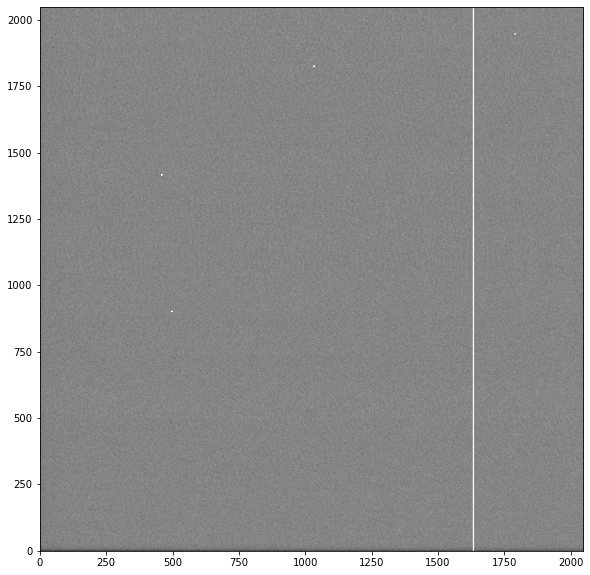

In [291]:
paths1109_a = [obs1109 + f'a{i:03d}.fits' for i in range(1, 15)]
paths1109_b = [obs1109 + f'a{i:03d}.fits' for i in range(33, 46)]
paths1109_c = [obs1109 + f'a{i:03d}.fits' for i in range(121, 134)]
#Since there were 3 sets of bias taken on this observation night, I decided to do all of them
paths1109 = paths1109_a + paths1109_b + paths1109_c
# show the master bias image
masterbias1109 = make_bias(paths1109)
show_image(masterbias1109)
print(np.mean(masterbias1109));

Observation 11/11

In [294]:
#2-11, 30-49, 126-145
# Two bias sets 
paths1111_a = [obs1111 + f'a{i:03d}.fits' for i in range(3, 11)] 
paths1111_b = [obs1111 + f'a{i:03d}.fits' for i in range(30, 49)] 
paths1111 = paths1111_a + paths1111_b
masterbias1111 = make_bias(paths1111)
print(np.mean(masterbias1111));

-0.03665661811828613


Observation 11/13

In [295]:
paths1113 = [obs1113 + f'a{i:03d}.fits' for i in range(3, 22)] 
masterbias1113 = make_bias(paths1113)
print(np.mean(masterbias1113));

-0.03665661811828613


Observation 11/16

In [296]:
# Two sets of bias
paths1116_a = [obs1116 + f'a{i:03d}.fits' for i in range(2,15)] 
paths1116_b = [obs1116 + f'a{i:03d}.fits' for i in range(34,48)] 
paths1116 = paths1116_a + paths1116_b
# show the master bias image
masterbias1116 = make_bias(paths1116)
print(np.mean(masterbias1116));

-0.03665661811828613


Observation 11/19 

In [297]:
paths1119 = [obs1119 + f'a{i:03d}.fits' for i in range(5,19)] 
masterbias1119 = make_bias(paths1119)
print(np.mean(masterbias1119));

-0.03665661811828613


Observation 11/30

In [298]:
paths1130 = [obs1130 + f'a{i:03d}.fits' for i in range(2,26)] 
# show the master bias image
masterbias1130 = make_bias(paths1130)
print(np.mean(masterbias1130));

-0.03665661811828613


Observation 12/04

In [299]:
paths1204 = [obs1204 + f'a{i:03d}.fits' for i in range(1,27)] 
# show the master bias image
masterbias1204 = make_bias(paths1204)
print(np.mean(masterbias1204));

-0.03665661811828613


All the masterbias for all observation dates (11-09 to 12-04) have the same mean: -0.03665661811828613.

## 1.2. Define Master Flats

In [292]:
def make_flat(paths, bias):
    """Combine the input images and return a master flat image."""
    datacube = None
    for path in paths:
        # load the image
        data = fits.getdata(path)
        # remove the overscan
        image = remove_overscan(data)
        # subtract the bias
        image = image - bias 
        image = image / np.median(image)
        # add to the stack
        image = np.expand_dims(image, axis=0)

        if datacube is None:
            datacube = image
        else:
            datacube = np.vstack((datacube, image))
        
        masterflat = np.median(datacube, axis=0)
            
    return masterflat

There were no Twilight Flats on 2021-11-19.

Observation 11/09

In [293]:
#twilight flats 
pathsB_1109 = [obs1109 + f'a{i:03d}.fits' for i in range(18, 22)]
masterflatB_1109 = make_flat(pathsB_1109, masterbias1109)

pathsV_1109 = [obs1109 + f'a{i:03d}.fits' for i in range(23, 27)]
masterflatV_1109 = make_flat(pathsV_1109, masterbias1109)

pathsR_1109 = [obs1109 + f'a{i:03d}.fits' for i in range(28, 32)]
masterflatR_1109 = make_flat(pathsR_1109, masterbias1109)

Observation 11/11

In [300]:
#twilight flats 
pathsB_1111 = [obs1111 + f'a{i:03d}.fits' for i in range(14, 18)]
masterflatB_1111 = make_flat(pathsB_1111, masterbias1111)

pathsV_1111 = [obs1111 + f'a{i:03d}.fits' for i in range(19, 23)]
masterflatV_1111 = make_flat(pathsV_1111, masterbias1111)

pathsR_1111 = [obs1111 + f'a{i:03d}.fits' for i in range(24, 29)]
masterflatR_1111 = make_flat(pathsR_1111, masterbias1111)

Observation 11/13

In [301]:
#twilight flats 
pathsB_1113 = [obs1113 + f'a{i:03d}.fits' for i in range(26, 30)]
masterflatB_1113 = make_flat(pathsB_1113, masterbias1113)

pathsV_1113 = [obs1113 + f'a{i:03d}.fits' for i in range(31, 35)]
masterflatV_1113 = make_flat(pathsV_1113, masterbias1113)

pathsR_1113 = [obs1113 + f'a{i:03d}.fits' for i in range(36, 40)]
masterflatR_1113 = make_flat(pathsR_1113, masterbias1113)

Observation 11/16

In [302]:
#twilight flats 
pathsB_1116 = [obs1116 + f'a{i:03d}.fits' for i in range(19, 23)]
masterflatB_1116 = make_flat(pathsB_1116, masterbias1116)

pathsV_1116 = [obs1116 + f'a{i:03d}.fits' for i in range(24, 28)]
masterflatV_1116 = make_flat(pathsV_1116, masterbias1116)

pathsR_1116 = [obs1116 + f'a{i:03d}.fits' for i in range(29, 33)]
masterflatR_1116 = make_flat(pathsR_1116, masterbias1116)

Observation 11/30

In [303]:
#twilight flats 
pathsB_1130 = [obs1130 + f'a{i:03d}.fits' for i in range(30, 34)]
masterflatB_1130 = make_flat(pathsB_1130, masterbias1130)

pathsV_1130 = [obs1130 + f'a{i:03d}.fits' for i in range(35, 39)]
masterflatV_1130 = make_flat(pathsV_1130, masterbias1130)

pathsR_1130 = [obs1130 + f'a{i:03d}.fits' for i in range(40, 44)]
masterflatR_1130 = make_flat(pathsR_1130, masterbias1130)

Observation 12/04

In [304]:
#twilight flats 
pathsB_1204 = [obs1204 + f'a{i:03d}.fits' for i in range(31, 35)]
masterflatB_1204 = make_flat(pathsB_1204, masterbias1204)

pathsV_1204 = [obs1204 + f'a{i:03d}.fits' for i in range(35, 40)]
masterflatV_1204 = make_flat(pathsV_1204, masterbias1204)

pathsR_1204 = [obs1204 + f'a{i:03d}.fits' for i in range(41, 45)]
masterflatR_1204 = make_flat(pathsR_1204, masterbias1204)

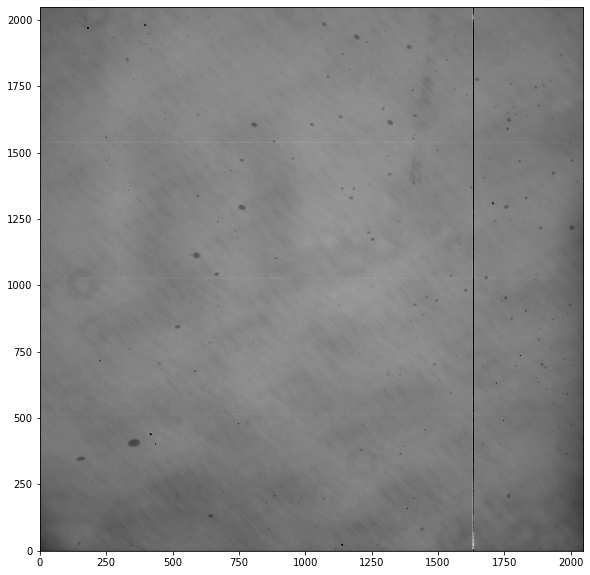

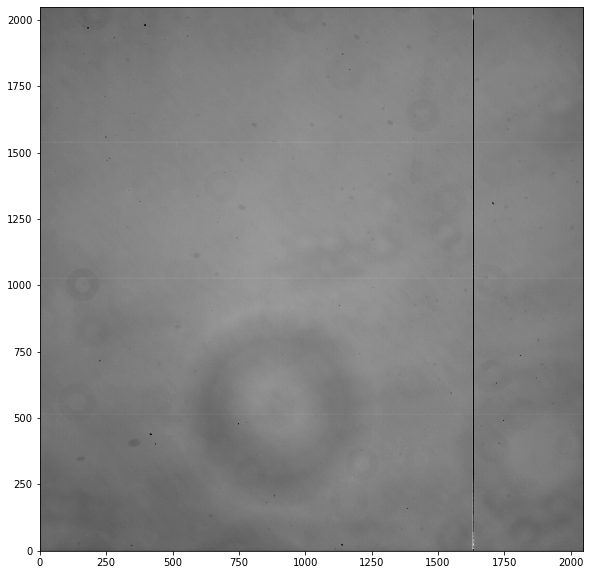

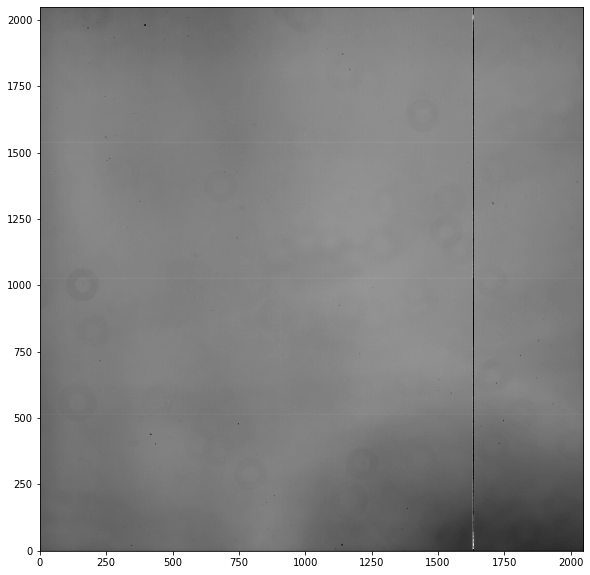

In [305]:
show_image(masterflatB_1204)#Twilight flat in B-band
show_image(masterflatV_1204)#Twilight flat in V-band
show_image(masterflatR_1204)#Twilight flat in R_OLD-band

## 1.3 Processed Images

Note: The science images were already processed throught WCS. I adjusted the coding to make sure the calibrated images keep the original headers and the WCS headers.

In [306]:
# process image data
def get_proc_image(bias, flat, targetimage, imname, file):
    """return a 2D numpy array representing a fully processed image"""
    image = fits.getdata(targetimage + imname)
    head = fits.getheader(targetimage + imname)
    image = remove_overscan(image)
    image = image - bias
    image = image / flat
    #create new file
    HDUList_image = fits.open(targetimage + imname)
    primaryHeader = HDUList_image[0].header
    hdu = fits.PrimaryHDU(image)
    hdu.header=primaryHeader #allows me to keep the original header
    hdu.writeto(file)
    
    return hdu

Test for output image and header

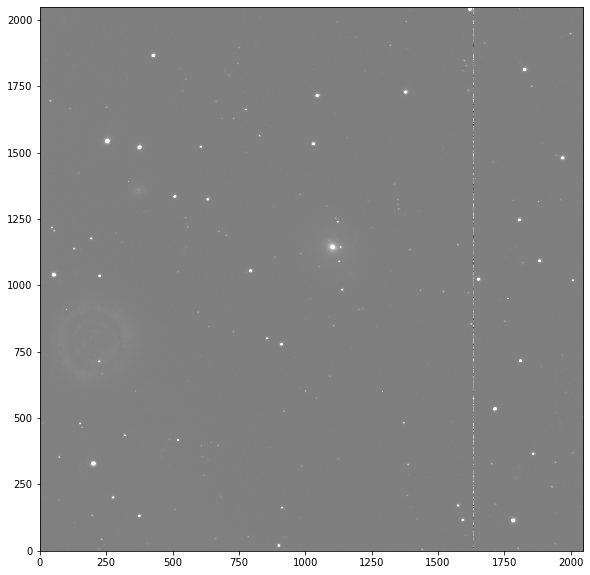

In [307]:
proc2021abzd_R_1109 = get_proc_image(masterbias1109, masterflatR_1109, obs1109, 'a117.fits', 'a117.proctest.fits')
new_imagec = fits.getdata('a117.proctest.fits')
show_image(new_imagec)

In [308]:
#Check WCS data and telescope info in header
heada = fits.getheader('a117.proctest.fits')
heada

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -64 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2048 / length of data axis 1                          
NAXIS2  =                 2048 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
LOCATION= 'MLO-40  '           / Observatory                                    
TELESCOP= '40-inch Reflector'  / Telescope                                      
LATITUDE=                32.

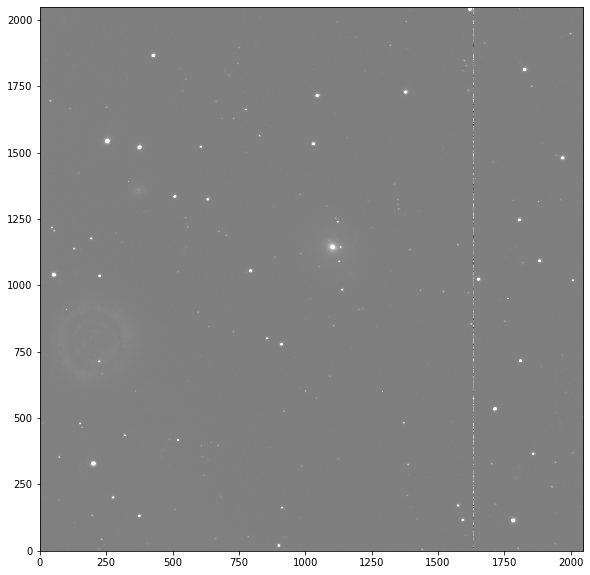

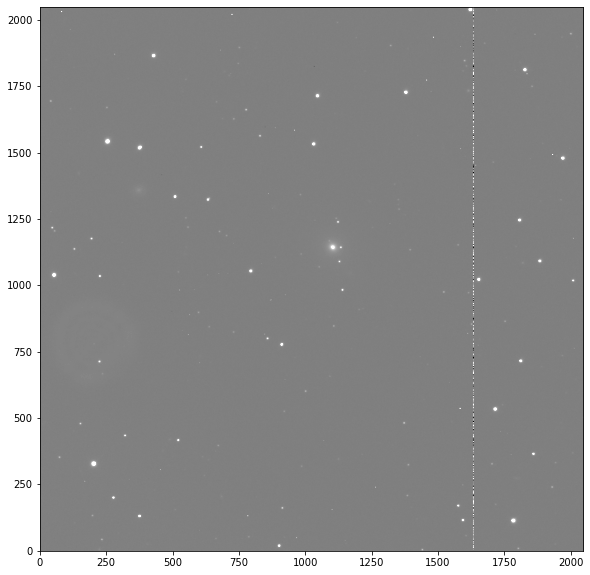

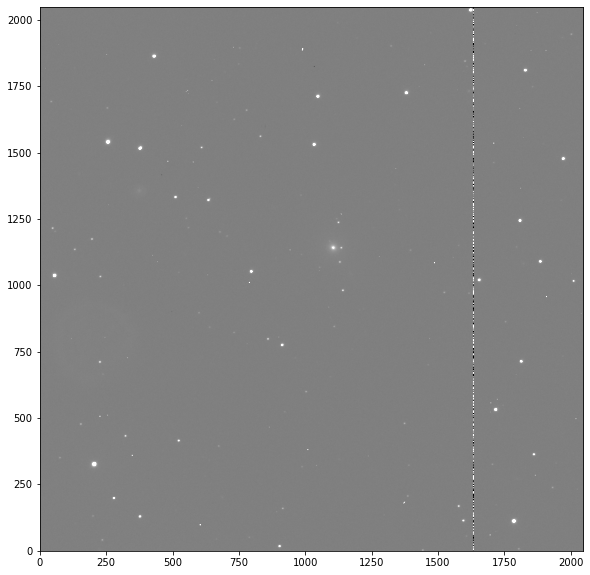

In [309]:
proc2021abzd_R_1109 = get_proc_image(masterbias1109, masterflatR_1109, obs1109, 'a117.fits', 'a117_WCS.fits')
new_image1 = fits.getdata('a117_WCS.fits')
show_image(new_image1)

proc2021abzd_V_1109 = get_proc_image(masterbias1109, masterflatV_1109, obs1109, 'a118.fits', 'a118_WCS.fits')
new_image2 = fits.getdata('a118_WCS.fits')
show_image(new_image2)

proc2021abzd_B_1109 = get_proc_image(masterbias1109, masterflatB_1109, obs1109, 'a119.fits', 'a119_WCS.fits')
new_image3 = fits.getdata('a119_WCS.fits')
show_image(new_image3)

In [310]:
proc2021abzd_R_1111 = get_proc_image(masterbias1111, masterflatR_1111, obs1111, 'a068.fits', 'a068_WCS.fits')

proc2021abzd_V_1111 = get_proc_image(masterbias1111, masterflatV_1111, obs1111, 'a069.fits', 'a069_WCS.fits')

proc2021abzd_B_1111 = get_proc_image(masterbias1111, masterflatB_1111, obs1111, 'a071.fits', 'a071_WCS.fits')

proc2021abzd_R_1113 = get_proc_image(masterbias1113, masterflatR_1113, obs1113, 'a099.fits', 'a099_WCS.fits')

proc2021abzd_V_1113 = get_proc_image(masterbias1113, masterflatV_1113, obs1113, 'a100.fits', 'a100_WCS.fits')

proc2021abzd_B_1113 = get_proc_image(masterbias1113, masterflatB_1113, obs1113, 'a101.fits', 'a101_WCS.fits')

proc2021abzd_R_1116 = get_proc_image(masterbias1116, masterflatR_1116, obs1116, 'a112.fits', 'a112_WCS.fits')

proc2021abzd_V_1116 = get_proc_image(masterbias1116, masterflatV_1116, obs1116, 'a113.fits', 'a113_WCS.fits')

proc2021abzd_B_1116 = get_proc_image(masterbias1116, masterflatB_1116, obs1116, 'a114.fits', 'a114_WCS.fits')

proc2021abzd_R_1119 = get_proc_image(masterbias1119, masterflatR_1116, obs1119, 'a043.fits', 'a043_WCS.fits')

proc2021abzd_V_1119 = get_proc_image(masterbias1119, masterflatV_1116, obs1119, 'a044.fits', 'a044_WCS.fits')

proc2021abzd_B_1119 = get_proc_image(masterbias1116, masterflatB_1116, obs1119, 'a045.fits', 'a045_WCS.fits')

proc2021abzd_R_1130 = get_proc_image(masterbias1130, masterflatR_1130, obs1130, 'a049.fits', 'a049_WCS.fits')

proc2021abzd_V_1130 = get_proc_image(masterbias1130, masterflatV_1130, obs1130, 'a050.fits', 'a050_WCS.fits')

proc2021abzd_B_1130 = get_proc_image(masterbias1130, masterflatB_1130, obs1130, 'a051.fits', 'a051_WCS.fits')

proc2021abzd_R_1204 = get_proc_image(masterbias1204, masterflatR_1204, obs1204, 'a062.fits', 'a062_WCS.fits')

proc2021abzd_V_1204 = get_proc_image(masterbias1204, masterflatV_1204, obs1204, 'a063.fits', 'a063_WCS.fits')

proc2021abzd_B_1204 = get_proc_image(masterbias1204, masterflatB_1204, obs1204, 'a065.fits', 'a065_WCS.fits')

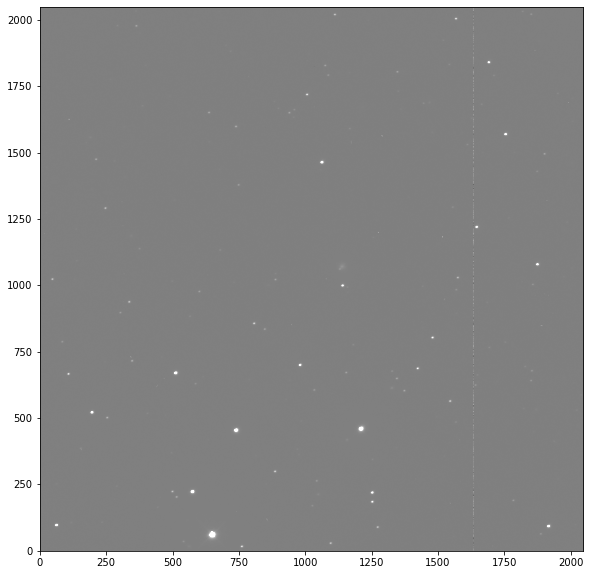

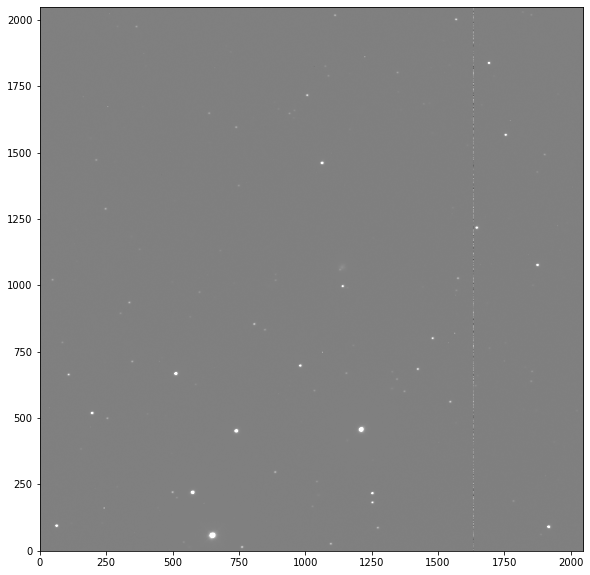

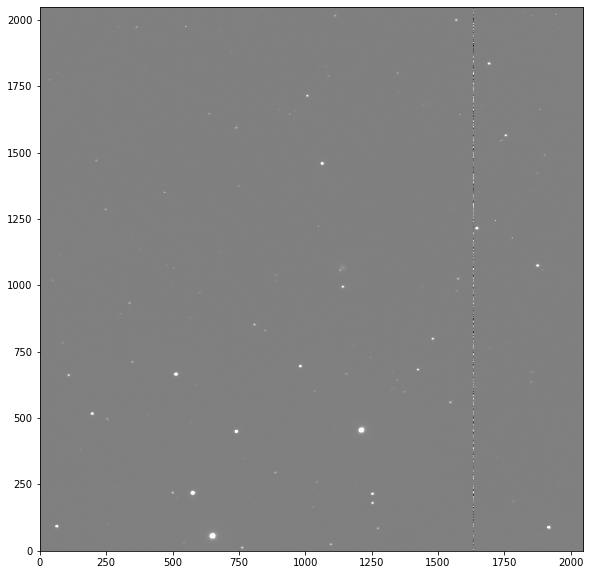

In [311]:
proc2021adlt_R_1109 = get_proc_image(masterbias1109, masterflatR_1109, obs1109, 'a143.fits', 'a143_WCS.fits')
new_image4 = fits.getdata('a143_WCS.fits')
show_image(new_image4)

proc2021adlt_V_1109 = get_proc_image(masterbias1109, masterflatV_1109, obs1109, 'a144.fits', 'a144_WCS.fits')
new_image5 = fits.getdata('a144_WCS.fits')
show_image(new_image5)

proc2021adlt_B_1109 = get_proc_image(masterbias1109, masterflatB_1109, obs1109, 'a145.fits', 'a145_WCS.fits')
new_image6 = fits.getdata('a145_WCS.fits')
show_image(new_image6)

In [315]:
proc2021adlt_R_1111 = get_proc_image(masterbias1111, masterflatR_1111, obs1111, 'a119.fits', 'a119_WCS.fits')

proc2021adlt_V_1111 = get_proc_image(masterbias1111, masterflatV_1111, obs1111, 'a120.fits', 'a120_WCS.fits')

proc2021adlt_B_1111 = get_proc_image(masterbias1111, masterflatB_1111, obs1111, 'a125.fits', 'a125_WCS.fits')

proc2021adlt_R_1113 = get_proc_image(masterbias1113, masterflatR_1113, obs1113, 'a128.fits', 'a128_WCS.fits')

proc2021adlt_V_1113 = get_proc_image(masterbias1113, masterflatV_1113, obs1113, 'a129.fits', 'a129_WCS.fits')

proc2021adlt_B_1113 = get_proc_image(masterbias1113, masterflatB_1113, obs1113, 'a131.fits', 'a131_WCS.fits')

proc2021adlt_R_1116 = get_proc_image(masterbias1116, masterflatR_1116, obs1116, 'a136.fits', 'a136_WCS.fits')

proc2021adlt_V_1116 = get_proc_image(masterbias1116, masterflatV_1116, obs1116, 'a137.fits', 'a137_WCS.fits')

proc2021adlt_B_1116 = get_proc_image(masterbias1116, masterflatB_1116, obs1116, 'a139.fits', 'a139_WCS.fits')

proc2021adlt_R_1119 = get_proc_image(masterbias1119, masterflatR_1116, obs1119, 'a069.fits', 'a069_WCS.fits')

proc2021adlt_V_1119 = get_proc_image(masterbias1119, masterflatV_1116, obs1119, 'a070.fits', 'a070_WCS.fits')

proc2021adlt_B_1119 = get_proc_image(masterbias1119, masterflatB_1116, obs1119, 'a072.fits', 'a072_WCS.fits')

proc2021adlt_R_1130 = get_proc_image(masterbias1130, masterflatR_1130, obs1130, 'a114.fits', 'a114_WCS.fits')

proc2021adlt_V_1130 = get_proc_image(masterbias1130, masterflatV_1130, obs1130, 'a115.fits', 'a115_WCS.fits')

proc2021adlt_B_1130 = get_proc_image(masterbias1130, masterflatB_1130, obs1130, 'a117.fits', 'a117_WCS.fits')

proc2021adlt_R_1204 = get_proc_image(masterbias1204, masterflatR_1204, obs1204, 'a150.fits', 'a150_WCS.fits')

proc2021adlt_V_1204 = get_proc_image(masterbias1204, masterflatV_1204, obs1204, 'a151.fits', 'a151_WCS.fits')

proc2021adlt_B_1204 = get_proc_image(masterbias1204, masterflatB_1204, obs1204, 'a153.fits', 'a153_WCS.fits')

^ All the processed files had to be renamed with the filter name in front to make it eaiser to organize. As shown in the next step.^

Here I am just processing a better image for the paper.

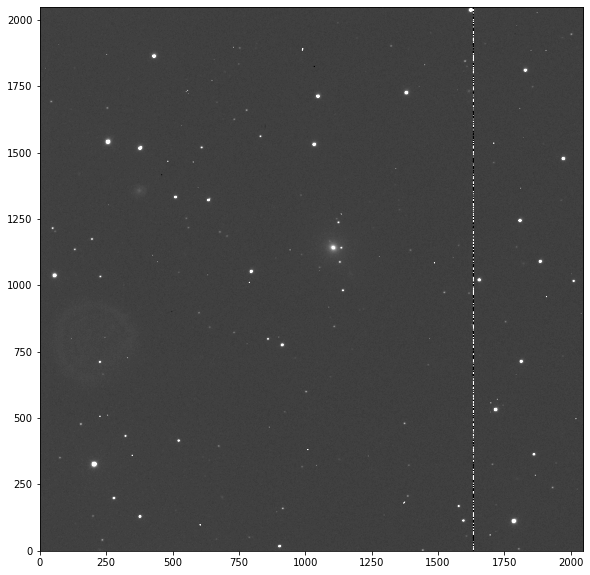

In [316]:
samplea = fits.getdata('B_WCS_a119.fits')

def show_pic(image):
    vmin = np.median(image) - np.std(image)
    vmax = np.median(image) + 3*np.std(image)
    plt.figure(figsize=(10,10))
    plt.imshow(image, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
    
show_pic(samplea)
#ax.imshow(samplea, origin='lower', cmap='gray', vmin=300, vmax =1000)

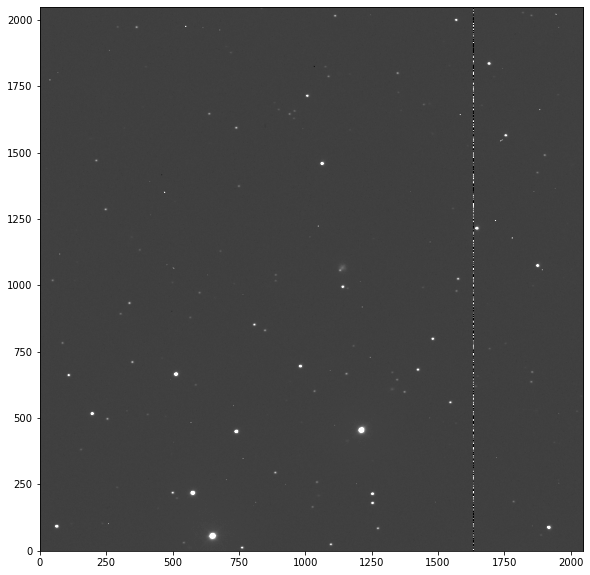

In [317]:
sampleb = fits.getdata('B_WCS_a145.fits')
show_pic(sampleb)

## Step 2

For your two objects, extract B and V band light curves (and optionally the R band). You should begin with simple aperture photometry. If you have a target that is significantly contaminated by light from its host galaxy you might also investigate using more advanced techniques such as PSF modeling and/or modeling of the host galaxy light.

After you have extracted the light curves for your two targets, save the data to a simple text file and **push this file to GitHub by the light curve deadline**. The name of this file should be in the form `studentname_lcs.dat`, where `studentname` is your first name. The files should be simple ASCII text files and contain a table of data. Each row of the table should give the name of the supernova (e.g., 2021abc), the modified julian date of the observation (e.g., 59176.9230), the filter (B, V, or R), the magnitude, and the magnitude uncertainty.

Submit your observed magnitudes, but note that for the steps below you will want to correct these values Galactic extinction. You may find `astroquery.irsa_dust.IrsaDust` helpful for this. You should use the CTIO B and V absorption (`A_SandF`) as appropriate. 
- This project 3. Create the phased diagram but will not need string-length method, you want a light curve. 

### 2.1 Photometery Setup

In [4]:
WCSdir_abzd = 'C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021abzd/'
WCSdir_adlt = 'C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021adlt/'

def get_filenames(datadir, f):
    """ return a list of strings giving the full path names to each FITS image """
    
    # suggestion: make use of the variable `DATADIR` defined above
    return sorted(glob(os.path.join(datadir, f+"*.fits")))

In [5]:
fname1_B = get_filenames(WCSdir_abzd, 'B')
fname1_V = get_filenames(WCSdir_abzd, 'V')
fname2_B = get_filenames(WCSdir_adlt, 'B')
fname2_V = get_filenames(WCSdir_adlt, 'V')

In [6]:
#2020abzd coordinates '00 43 35.859 +30 35 32.65' 
#2020adlt coordinates '04 39 11.879 +06 22 24.38' 
#00:43:35.859	+30:35:32.65

def get_target_pos_abzd():
    """Return a SkyCoord object representing the position of the target on the sky"""
    return SkyCoord('00 43 35.859 +30 35 32.65', unit=(u.hour, u.deg))

def get_target_pos_adlt():
    """Return a SkyCoord object representing the position of the target on the sky"""
    return SkyCoord('04 39 11.879 +06 22 24.38', unit=(u.hour, u.deg))

In [7]:
get_target_pos_abzd()

<SkyCoord (ICRS): (ra, dec) in deg
    (10.8994125, 30.59240278)>

In [8]:
def pick_refstars_abzd(radius=4*u.arcmin):
    """ 
    return a structured numpy array (or Astropy Table) with columns giving the 'name', 'ra',
    and 'dec', 'Rmag', and 'e_Rmag' of comparison stars within the supplied radius of the target.
    
    This function should query VizieR to find stars near the target position, calculate the R-band
    magnitude ('Rmag') and uncertainty ('e_Rmag') for each star, and remove stars that have R-band
    magnitudes fainter than 19 mag. Also, the target should **not** be included.
    
    'ra' and 'dec' should be given in decimal degrees
    
    'name' should be any convenient identifier (e.g., 'refstar001')
    
    radius is the maximum angular distance from the target allowed
    """

    # get the target position
    target = get_target_pos_abzd()

    # find reference stars near the target
    vizR = Vizier(columns=['recno', 'RAJ2000', 'DEJ2000', 'Vmag', 'e_Vmag', 'B-V', 'e_B-V'])
    #name is LGGS, want Vmag, V-R, ra is RAJ2000, dec is DEJ2000, 
    vizR.ROW_LIMIT= -1
    #ROW_LIMIT = -1 gives the full data
    ref_target = vizR.query_region(target, catalog="II/336/apass9", radius=1*u.arcmin)
    # II/336/apass9 is The APASS catalog of AAVSO Photometric All Sky Survey (APASS) DR9 (Henden+, 2016) 
    # recno can be used as a name designation
    table = ref_target[0]
    
    #Rename column for name of reference stars, had to do this first due to how the code was processed
    table.rename_column('recno', 'name')
    
    
    # get the R-band magnitudes for each nearby star
    # (convert the V magnitude and V-R color to an R-band value)
    Bmag = (table['B-V'] + table['Vmag'])
    e_Bmag = (table['e_B-V'] + table['e_Vmag'])
    
    #unit conversion
    unit = SkyCoord(table['RAJ2000'], table['DEJ2000'], unit=(u.hourangle,u.deg))
    ura = unit.ra.deg
    udec = unit.dec.deg
    
    #relabel table
    table['RAJ2000'] = ura
    table['DEJ2000'] = udec
    table.rename_column('RAJ2000', 'RA')
    table.rename_column('DEJ2000', 'Dec')
    table['B-V'] = Bmag
    table['e_B-V'] = e_Bmag
    table.rename_column('B-V', 'Bmag')
    table.rename_column('e_B-V', 'e_Bmag')
    
    # just keep objects brighter than B~20 mag 
    Bmag20 = (Bmag <= 20) 
    refstars_table = table[Bmag20]

    
    # don't include the target in the refstar list! (Get rid of a row)
    refstars_pos = SkyCoord(refstars_table['RA'], refstars_table['Dec'], unit='deg')
    w = refstars_pos.separation(target) > 2*u.arcsec
    
    #name of reference stars
    ref_i = refstars_table[w]
    ref_i['name'] = ['refstar{:03d}'.format(i) for i in range(0, len(ref_i))]
    refstars = ref_i
    
    # return structured numpy or Astropy Table (one row for each refstar)
    return refstars

In [9]:
pick_refstars_abzd(radius=4*u.arcmin)

C:\ProgramData\Anaconda3\lib\site-packages\astropy\table\column.py:1020: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(super(), op)(other)


name,RA,Dec,Vmag,e_Vmag,Bmag,e_Bmag
,,,mag,mag,,
str10,float64,float64,float32,float32,float32,float32
refstar000,10.898639000000001,30.601847,16.463,0.000,17.158998,0.057
refstar001,10.902144000000002,30.586936,13.883,0.047,14.924001,0.15799999
refstar002,10.898250000000003,30.602756,16.176,0.000,16.673,0.114


In [10]:
def pick_refstars_adlt(radius=2*u.arcmin):
    """ 
    return a structured numpy array (or Astropy Table) with columns giving the 'name', 'ra',
    and 'dec', 'Rmag', and 'e_Rmag' of comparison stars within the supplied radius of the target.
    
    This function should query VizieR to find stars near the target position, calculate the R-band
    magnitude ('Rmag') and uncertainty ('e_Rmag') for each star, and remove stars that have R-band
    magnitudes fainter than 19 mag. Also, the target should **not** be included.
    
    'ra' and 'dec' should be given in decimal degrees
    
    'name' should be any convenient identifier (e.g., 'refstar001')
    
    radius is the maximum angular distance from the target allowed
    """

    # get the target position
    target = get_target_pos_adlt()

    # find reference stars near the target
    vizR = Vizier(columns=['recno', 'RAJ2000', 'DEJ2000', 'Vmag', 'e_Vmag', 'B-V', 'e_B-V'])
    #name is LGGS, want Vmag, V-R, ra is RAJ2000, dec is DEJ2000, 
    vizR.ROW_LIMIT= -1
    #ROW_LIMIT = -1 gives the full data
    ref_target = vizR.query_region(target, catalog="II/336/apass9", radius=1*u.arcmin)
    # II/336/apass9 is The APASS catalog of AAVSO Photometric All Sky Survey (APASS) DR9 (Henden+, 2016) 
    # recno can be used as a name designation
    table = ref_target[0]
    
    #Rename column for name of reference stars, had to do this first due to how the code was processed
    table.rename_column('recno', 'name')
    
    
    # get the R-band magnitudes for each nearby star
    # (convert the V magnitude and V-R color to an R-band value)
    Bmag = (table['B-V'] + table['Vmag'])
    e_Bmag = (table['e_B-V'] + table['e_Vmag'])
    
    #unit conversion
    unit = SkyCoord(table['RAJ2000'], table['DEJ2000'], unit=(u.hourangle,u.deg))
    ura = unit.ra.deg
    udec = unit.dec.deg
    
    #relabel table
    table['RAJ2000'] = ura
    table['DEJ2000'] = udec
    table.rename_column('RAJ2000', 'RA')
    table.rename_column('DEJ2000', 'Dec')
    table['B-V'] = Bmag
    table['e_B-V'] = e_Bmag
    table.rename_column('B-V', 'Bmag')
    table.rename_column('e_B-V', 'e_Bmag')
    
    # just keep objects brighter than B~20 mag 
    Bmag20 = (Bmag <= 20) 
    refstars_table = table[Bmag20]

    
    # don't include the target in the refstar list! (Get rid of a row)
    refstars_pos = SkyCoord(refstars_table['RA'], refstars_table['Dec'], unit='deg')
    w = refstars_pos.separation(target) > 2*u.arcsec
    
    #name of reference stars
    ref_i = refstars_table[w]
    ref_i['name'] = ['refstar{:03d}'.format(i) for i in range(0, len(ref_i))]
    refstars = ref_i
    
    # return structured numpy or Astropy Table (one row for each refstar)
    return refstars


In [11]:
pick_refstars_adlt(radius=2*u.arcmin)

name,RA,Dec,Vmag,e_Vmag,Bmag,e_Bmag
,,,mag,mag,,
str10,float64,float64,float32,float32,float32,float32
refstar000,69.79816100000001,6.379615,15.014,0.037,16.053,0.085999995
refstar001,69.798574,6.372603,15.672,0.052,16.393,0.174


In [12]:
def get_counts(image, xs, ys, radius):
    """
    Return the total (local background subtracted) counts in a circular aperture 
    
    `image` -- the 2D numpy array holding the counts recorded at each pixel
    `xs` -- an array of x-positions for the aperture centers
    `ys` -- an array of y-positions for the aperture centers
    `radius` -- radius (float) of the circular apertures in pixels
    """

    #to deal with array from 1D and 2D
    xs=np.array(xs).flatten()
    ys=np.array(ys).flatten()
    #flatten() is for the get_photometery function due to the target arry being a different dimension 
    #then the refstars
    
    # x, y coordinates for each pixel in the image
    imy, imx = np.indices(image.shape)
    
    #size of image
    dy, dx = image.shape
    # from 'Photometry' lecture
    
    # Start by creating an empty list to hold the measurements.
    # The loop below will add one row to this list at a time.
    # Each row will be a numpy structured array with columns named "counts" and "ecounts".
    # At the end, `measurements` will be converted from a list object to a numpy array.
    measurements = []
    dtype = [('counts', float), ('ecounts', float)]

    # determine the local background level for each position
    for x, y in zip(xs, ys):
        #print(radius)
        # make sure the aperture is fully contained on the image
        if (x < radius) | (x > dx - radius) | (y < radius) | (y > dy - radius):
            # | is the logical "or" operator
            measurements.append( np.array( (np.nan, np.nan), dtype=dtype) )
            continue
        
        # define a circular aperture at this x, y
        #place radius in all parts of fwhm
        aperture = photutils.CircularAperture((x, y), radius)

        # measure the counts in this aperture
        phot_table = photutils.aperture_photometry(image, aperture)
        phot = phot_table[0]
    
        # determine the distance from this x,y to each pixel in the image
        # hint: use imx and imy defined above
        dists = np.sqrt((x - imx)**2 + (y -imy)**2)

        # define a truth array, wbg, that is True only for image pixels 
        # from 4 * radius to 6 * radius from the target. This annulus
        # will be used to define the local background.
        wbg = (dists >= (4*radius)) & (dists <= (6*radius))
        
        # find the local background values in the annulus
        bg_sample = sigma_clip(image[wbg])
        
        # subtract the background contribution from the aperture sum
        #bg_counts = aperture.area * bg_sample.var()
        counts = phot['aperture_sum'] - bg_sample.mean()*aperture.area

        # get the uncertainty
        obj_var = counts
        bg_var = aperture.area * bg_sample.var()
        avbg_var = (bg_sample.std()**2) / (bg_sample.size * aperture.area**2)
        ecounts = np.sqrt( obj_var + bg_var +  avbg_var)

        # add this measurement
        measurements.append( np.array( (counts, ecounts), dtype=dtype) )
    measurements = np.array(measurements)
        
    return measurements['counts'], measurements['ecounts']


In [13]:
# test your code
# For example, test what get_counts returns for a blank patch of sky. Does this make sense?
# for image, xs, xy, radius -> photometry
files = fname1_V
image = fits.getdata(files[0])
get_counts(image, 50, 50, 1)#this is the background data
#reminder your radius/fwhm is in pixels so don't define an unit for this

(array([110.36951122]), array([57.71563908]))

In [14]:
test = fits.getheader(WCSdir_abzd + 'B_WCS_a045.fits')
test['FILTER']

'B'

In [15]:
# (inverse) gain of the PTF camera
GAIN = 2.13 # photoelectrons per count

def get_photometry(fnames, target, refstars, refmag, tarname): #, refnum
#put input for the 5 on the w.sum):
    # get the list of image files to work with
    #fnames = get_filenames()

    # get the target position
    #target = get_target_pos()

    # get the list of reference stars
    #refstars = pick_refstars()

    # Start by creating an empty list to hold the measurements.
    # The loop below will add one row to this list at a time.
    # Each row will be a numpy structured array with name, hjd, mag, and emag columns.
    # At the end, `data` will be converted from a list object to a numpy array.
    data = []
    dtype = [('name', 'U20'), ('mjd', float), ('filter', 'U20'), ('mag', float), ('emag', float)]

    # loop over each file to measure the counts for the target and refstars
    for ifile, fname in enumerate(fnames):
        print("({}/{}: {}".format(ifile, len(fnames), fname))
        
        # load the header and image data
        hdu = fits.open(fname) #loads the information
        image = hdu[0].data #image data
        head = hdu[0].header #header data

        # convert counts/pixel to photons/pixel
        image *= GAIN

        # get the julian day from the header
        mjd = float(head['J_DATE'][0:13]) - 2400000.5

        # we will do photometry in a 1*fwhm radius aperture, so
        # we need the fwhm from the header
        radius = head['FWHM']
        
        # get the wcs solution from the header
        imwcs = wcs.WCS(head)

        # determine the x, y locations of the reference stars
        refx, refy = imwcs.wcs_world2pix(refstars['RA'], refstars['Dec'], 0) # make sure you specify the origin is at 0 (not 1)

        # get the refstar counts
        refcounts, erefcounts = get_counts(image, refx, refy, radius)

        # require that all of the refstars are well detected (signal-to-noise ratio > 3)
        # and on the image (get_counts will return nan if the object is outside the image)
        w = (refcounts/erefcounts) > 0 #signal-to-noise ratio 
        #stn had to be reduced to 0 in order to get all data from all observation nights
        v = ~np.isfinite(refcounts) #remove stars on the edge of image that have 'nan', ~ make sure a number is returned
        # '~' is the truth array
        #signal-to-noise is just the counts over uncertanity 
        if (w.sum() < w.size) or (v.sum() > 0): #
        #make it doesn't give either one
        #this is based on that six appear in ref stars and make sure they are well dectected
        #sum of a boolan array helps flats out how many are true
            # missing/bad refstars
            continue
        
        # determine zeropoints from each refstar
        zps = refmag + 2.5*np.log10(refcounts) #refmag is the measured photometry
        #in this case you need Rmag from the pick_refstars

        # determine the best zeropoint for this image
        zp = zps.mean() #combine the data for best zeropoint
        #this averages out the zeropoints

        # record the magnitudes for each reference star
        for name, counts, ecounts in zip(refstars['name'], refcounts, erefcounts):
            mag = zp - 2.5 * np.log10(counts)
            emag = (2.5 / np.log(10))*(ecounts/counts)
            #data.append( np.array((name, jd, mag, emag), dtype=dtype) )

        # *** now for the target ***
        x, y = imwcs.wcs_world2pix(target.ra,target.dec, 0)
        counts, ecounts = get_counts(image, x, y, radius)

        # make sure the target counts are finite
        # and that the target is well detected (signal-to-noise ratio > 3)
        if ((counts/ecounts) <= 3) or (~np.isfinite(counts)) :
            # missing/bad target
            continue
            
        # record target measurement
        mag = zp - 2.5 * np.log10(counts)
        emag = (2.5 / np.log(10))*(ecounts/counts)
        data.append( np.array((tarname, mjd, head['FILTER'], mag, emag), dtype=dtype) ) #target should be head['OBJECT']

    return np.array(data)


Due to unable to get all data on "SN 2021abzd" from the photometry process, the signal-to- had to be reduced to 0 in order to obtain data from all 7 observation nights. This might be due to whole the images were processed or, according to observation logs, cloud cover could have effected the counts. 

In [16]:
import warnings
warnings.filterwarnings('ignore')
target1 = get_target_pos_abzd()
refstars1 = pick_refstars_abzd()
data1_B = get_photometry(fname1_B, target1, refstars1, refstars1['Bmag'], '2021abzd')
data1_V = get_photometry(fname1_V, target1, refstars1, refstars1['Vmag'], '2021abzd')

(0/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021abzd\B_WCS_a045.fits
(1/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021abzd\B_WCS_a051.fits
(2/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021abzd\B_WCS_a062.fits
(3/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021abzd\B_WCS_a071.fits
(4/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021abzd\B_WCS_a101.fits
(5/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021abzd\B_WCS_a114.fits
(6/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021abzd\B_WCS_a119.fits
(0/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021abzd\V_WCS_a044.fits
(1/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fal

In [17]:
target2 = get_target_pos_adlt()
refstars2 = pick_refstars_adlt()
data2_B = get_photometry(fname2_B, target2, refstars2, refstars2['Bmag'], '2021adlt')
data2_V = get_photometry(fname2_V, target2, refstars2, refstars2['Vmag'], '2021adlt')

(0/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021adlt\B_WCS_a072.fits
(1/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021adlt\B_WCS_a117.fits
(2/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021adlt\B_WCS_a125.fits
(3/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021adlt\B_WCS_a131.fits
(4/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021adlt\B_WCS_a139.fits
(5/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021adlt\B_WCS_a145.fits
(6/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021adlt\B_WCS_a153.fits
(0/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/obs_final_images/targetWCS/2021adlt\V_WCS_a070.fits
(1/7: C:/Users/jjuni/OneDrive/Documents/SDSU/Fal

In [18]:
data1_B

array([('2021abzd', 59537.2069 , 'B', 16.50592922, 0.20224597),
       ('2021abzd', 59548.07242, 'B', 17.27827457, 0.07068099),
       ('2021abzd', 59552.07776, 'B', 17.14205449, 0.05672651),
       ('2021abzd', 59529.12017, 'B', 15.60476228, 0.01815216),
       ('2021abzd', 59531.23965, 'B', 16.4373163 , 0.03139717),
       ('2021abzd', 59534.22059, 'B', 17.12844956, 0.0880616 ),
       ('2021abzd', 59527.23838, 'B', 15.28472106, 0.01534821)],
      dtype=[('name', '<U20'), ('mjd', '<f8'), ('filter', '<U20'), ('mag', '<f8'), ('emag', '<f8')])

### 2.2 Create dat. file

In [20]:
dtype = [('name', 'U20'), ('mjd', float), ('filter', 'U20'), ('mag', float), ('emag', float)]
data = np.concatenate([data1_B, data1_V, data2_B, data2_V])
data

array([('2021abzd', 59537.2069 , 'B', 16.50592922, 0.20224597),
       ('2021abzd', 59548.07242, 'B', 17.27827457, 0.07068099),
       ('2021abzd', 59552.07776, 'B', 17.14205449, 0.05672651),
       ('2021abzd', 59529.12017, 'B', 15.60476228, 0.01815216),
       ('2021abzd', 59531.23965, 'B', 16.4373163 , 0.03139717),
       ('2021abzd', 59534.22059, 'B', 17.12844956, 0.0880616 ),
       ('2021abzd', 59527.23838, 'B', 15.28472106, 0.01534821),
       ('2021abzd', 59537.20435, 'V', 15.76993803, 0.05268249),
       ('2021abzd', 59548.06983, 'V', 16.53323131, 0.04076295),
       ('2021abzd', 59552.08024, 'B', 16.70454592, 0.05755544),
       ('2021abzd', 59529.11524, 'V', 15.00002418, 0.01066808),
       ('2021abzd', 59531.23623, 'V', 15.75713092, 0.01728966),
       ('2021abzd', 59534.21796, 'V', 15.80879566, 0.0306503 ),
       ('2021abzd', 59527.23528, 'V', 14.23218145, 0.0094704 ),
       ('2021adlt', 59537.28873, 'B', 16.84846412, 0.08907582),
       ('2021adlt', 59548.24969, 'B', 16

In [319]:
#save light curves to dat file
file = np.savetxt('JosephSoliz_lcs.dat', data, fmt='%s')

2.2a Showing the shared student dat file

In [21]:

SNcolnm = [('name','U20'),('mjd','f8'),('filter','U20'), ('mag','f8'),('emag','f8')]
SNdata = np.genfromtxt('shared_lcs_2021.dat', dtype=SNcolnm)
SNdata

array([('2021aazk', 59527.172, 'R', 18.936,  4.200e-02),
       ('2021aazk', 59529.157, 'R', 18.762,  4.100e-02),
       ('2021aazk', 59531.145, 'R', 18.592,  7.000e-02),
       ('2021aazk', 59548.113, 'R', 19.849,  9.800e-02),
       ('2021aazk', 59552.149, 'R', 19.698,  8.900e-02),
       ('2021aazk', 59527.174, 'V', 18.863,  4.800e-02),
       ('2021aazk', 59529.159, 'V', 19.067,  6.900e-02),
       ('2021aazk', 59531.151, 'V', 19.16 ,  1.190e-01),
       ('2021aazk', 59548.116, 'V', 20.265,  1.740e-01),
       ('2021aazk', 59552.152, 'V', 20.644,  1.900e-01),
       ('2021aazk', 59527.174, 'B', 19.65 ,  6.700e-02),
       ('2021aazk', 59529.162, 'B', 20.008,  1.040e-01),
       ('2021aazk', 59548.119, 'B', 21.001,  1.630e-01),
       ('2021aazk', 59552.154, 'B', 21.158,  1.540e-01),
       ('2021aazk', 59527.   , 'B', 19.845,  4.900e-02),
       ('2021aazk', 59529.   , 'B', 20.059,  8.900e-02),
       ('2021aazk', 59531.   , 'B', 20.353,  2.020e-01),
       ('2021aazk', 59548.   , 

### 2.3 Obtainting galactic extinction
 https://astroquery.readthedocs.io/en/v0.1-0/irsa_dust.html

In [22]:
from astroquery.irsa_dust import IrsaDust
table_abzd = IrsaDust.get_extinction_table('00 43 35.859 +30 35 32.65', radius=2.0 * u.deg)
table_adlt = IrsaDust.get_extinction_table('04 39 11.879 +06 22 24.38', radius=2.0 * u.deg)
print(table_adlt)

Filter_name LamEff A_over_E_B_V_SandF A_SandF A_over_E_B_V_SFD A_SFD
            micron                      mag                     mag 
----------- ------ ------------------ ------- ---------------- -----
     CTIO U 0.3734              4.107   0.632            4.968 0.765
     CTIO B 0.4309              3.641   0.561            4.325 0.666
     CTIO V 0.5517              2.682   0.413             3.24 0.499
     CTIO R  0.652              2.119   0.326            2.634 0.406
     CTIO I 0.8007              1.516   0.233            1.962 0.302
   DSS-II g 0.4621              3.381   0.521            3.907 0.602
   DSS-II r 0.6546              2.088   0.321            2.649 0.408
   DSS-II i 0.8111              1.487   0.229            1.893 0.291
     SDSS u 0.3587              4.239   0.653            5.155 0.794
     SDSS g 0.4717              3.303   0.509            3.793 0.584
        ...    ...                ...     ...              ...   ...
    UKIRT K   2.19              0.

In [23]:
# use the CTIO B and V absorption (A_SandF) as appropriate
extinctB_abzd = table_abzd['Filter_name'] == 'CTIO B' 
extinctV_abzd = table_abzd['Filter_name'] == 'CTIO V' 
extinctB_adlt = table_adlt['Filter_name'] == 'CTIO B' 
extinctV_adlt = table_adlt['Filter_name'] == 'CTIO V' 
table_adlt[extinctB_adlt]

Filter_name,LamEff,A_over_E_B_V_SandF,A_SandF,A_over_E_B_V_SFD,A_SFD
,micron,,mag,,mag
str8,float64,float64,float64,float64,float64
CTIO B,0.4309,3.641,0.561,4.325,0.666


In [24]:
ext1_B = float(table_abzd[extinctB_abzd]['A_SandF'])
ext1_V = float(table_abzd[extinctV_abzd]['A_SandF'])
ext2_B = float(table_adlt[extinctB_adlt]['A_SandF'])
ext2_V = float(table_adlt[extinctV_adlt]['A_SandF'])

### 2.4 Plot of Light Curves

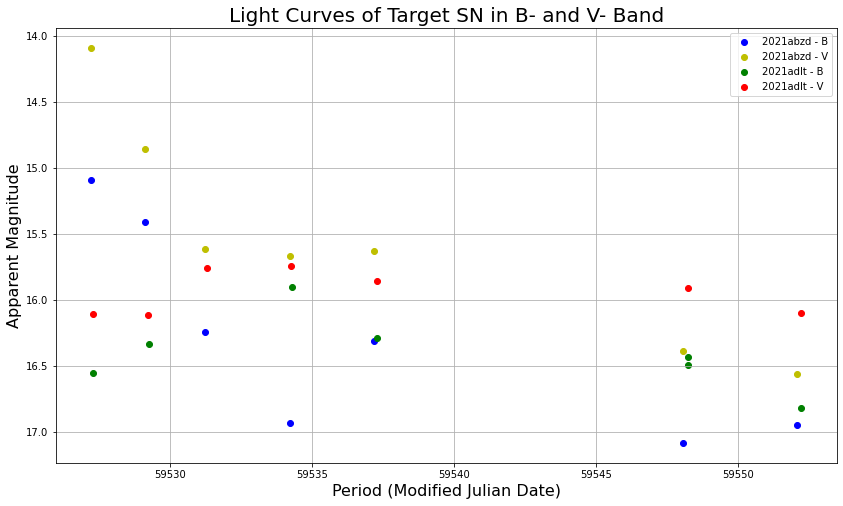

In [25]:
#plotting the light curves with extinction
t1 = data1_B['mjd']
mag1 = data1_B['mag'] - ext1_B
t2 = data1_V['mjd']
mag2 = data1_V['mag'] - ext1_V
t3 = data2_B['mjd']
mag3 = data2_B['mag'] - ext2_B
t4 = data2_V['mjd']
mag4 =data2_V['mag'] - ext2_V


plt.figure(figsize=(14,8))
plt.scatter(t1, mag1, c='b', label='2021abzd - B')
plt.scatter(t2, mag2, c='y', label='2021abzd - V')
plt.scatter(t3, mag3, c='g', label='2021adlt - B')
plt.scatter(t4, mag4, c='r', label='2021adlt - V')
plt.gca().invert_yaxis() #invert the axis on brightness from hightest to lowest above
plt.xlabel('Period (Modified Julian Date)', fontsize=16)
plt.ylabel('Apparent Magnitude', fontsize=16)
plt.title('Light Curves of Target SN in B- and V- Band', fontsize= 20)
plt.legend()
plt.grid();

## Step 3

Fit a Type Ia supernova template to your target light curves. You can use [Eric Hsiao's templates](http://adsabs.harvard.edu/abs/2007ApJ...663.1187H), which were discussed in class (see `lectures/media/SNIa_lc_template.dat`). These templates are essentially a table of magnitudes relative to **B-band maximum at certain phases**. You can interpolate these to arbitrary phases using `scipy.interpolate.interp1d`. It is possible to simultaneously fit all observed filters, but for simplicity you may fit one band at a time.

You will need (at least) three parameters in your fits: 1) the date, `jdmax`, of maximum B-band brightness, 2) the apparent B-band magnitude, `peakmag`, at B-band maximum, and 3) the `stretch` parameter to adjust how quickly the template rises and fades. Hint: to convert from observer day to template phase, you will want to do something like `phase = (jdobs - jdmax) / stretch`.

After you have found your best fit model parameters, you can determine the decline rate parameter, $\Delta m_{15}$ from your scaled templates.

- Lecture 27, and general models such as Project 2 and 3. chi^2 mininization. 
- Create a phase diagram based on the three parmaters: `phase = (jdobs - jdmax) / stretch`
* Compare my target observations to Hsiao's template. I need to plot them where you interpolate the phase = (jdobs - jdmax) / stretch. Add peakmag to the template points to make your model points. 
* From this, I find the three parameters. And then chi^2.
* get chi^2 function will compute the chi^2 of the tempelate model and observation data
* seperate the function to minimize the chi^2, i.e. find the best-fit model parameters
- best_fit = fmin(get_chisq, guess, args=(data,))
- best_fit
* after parameters are given then, create a phase diagram 
* then get delta_m_15

### 3.0 Hsiao's template

In [26]:

EHcolnames = ['phase', 'U', 'B', 'V', 'R', 'I', 'Y', 'J', 'H', 'K']
EHdata =  np.genfromtxt('C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/lectures/media/SNIa_lc_template.dat', names=EHcolnames)
EHdata

array([(-20.,  7.37467e+01, 7.42374e+01, 7.36345e+01, 7.30829e+01, 72.3734, 71.5946, 70.9369, 69.915 , 68.8001),
       (-19.,  6.89700e+00, 7.61100e+00, 7.68000e+00, 7.60800e+00,  7.62  ,  7.6457,  7.6821,  7.6731,  7.5824),
       (-18.,  4.42500e+00, 5.13900e+00, 5.20800e+00, 5.13600e+00,  5.147 ,  5.1734,  5.2028,  5.2009,  5.1077),
       (-17.,  3.29800e+00, 4.01200e+00, 4.08100e+00, 4.01000e+00,  4.021 ,  4.0484,  4.069 ,  4.076 ,  3.9795),
       (-16.,  2.56000e+00, 3.27500e+00, 3.34400e+00, 3.27200e+00,  3.283 ,  3.3114,  3.322 ,  3.3392,  3.2391),
       (-15.,  2.01100e+00, 2.72500e+00, 2.79400e+00, 2.72200e+00,  2.733 ,  2.7626,  2.7624,  2.7906,  2.6866),
       (-14.,  1.57200e+00, 2.28700e+00, 2.35600e+00, 2.28400e+00,  2.295 ,  2.3258,  2.3144,  2.3542,  2.2463),
       (-13.,  1.20800e+00, 1.92200e+00, 1.99100e+00, 1.91900e+00,  1.931 ,  1.963 ,  1.9404,  1.9924,  1.8811),
       (-12.,  8.96000e-01, 1.61000e+00, 1.67900e+00, 1.60700e+00,  1.618 ,  1.6512,  1.6174,  1

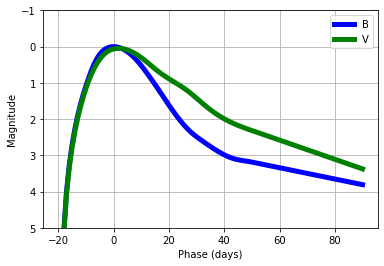

In [55]:
filts = ['B', 'V']
colors = dict( zip(filts, ('b', 'g')) )
for filt in filts:
    plt.plot(EHdata['phase'], EHdata[filt], color=colors[filt], lw=5, label=filt)
plt.xlabel('Phase (days)')
plt.ylabel('Magnitude')
plt.ylim(5, -1)
plt.legend(), plt.grid();

### 3.1 Calculating $\chi^{2}$ and the best fit parameters 

In [133]:
#Truth array for B and V band
B = SNdata['filter'] == 'B'
V = SNdata['filter'] == 'V'
SNdataB = SNdata[B]
SNdataV = SNdata[V]

#Truth array of 2021abzd and 2021adlt from student data
dataB_abzd = SNdataB['name'] == '2021abzd'
dataV_abzd = SNdataV['name'] == '2021abzd'
dataB_adlt = SNdataB['name'] == '2021adlt'
dataV_adlt = SNdataV['name'] == '2021adlt'
SNdataB1 = SNdataB[dataB_abzd]
SNdataV1 = SNdataV[dataV_abzd]
SNdataB2 = SNdataB[dataB_adlt]
SNdataV2 = SNdataV[dataV_adlt]

In [139]:
#interpolate for the Hsiao's template
#jdmax is params[0], stretch is params[1], peakmag is params[2]
#this is for the B-band
def target_model(params, t):
    phase = (t - params[0]) / params[1]
    f = scipy.interpolate.interp1d(EHdata['phase'], EHdata['B'], fill_value = 'extrapolate')
    y = f(phase) + params[2]
    return phase, y

#for V band
def target_model_V(params, t):
    phaseV = (t - params[0]) / params[1]
    f = scipy.interpolate.interp1d(EHdata['phase'], EHdata['V'], fill_value = 'extrapolate')
    yv = f(phaseV) + params[2]
    return phaseV, yv

In [140]:
# write a function to calculate the chi-squared value given the model and data
# data is jdobs
def get_chisq(params, data):
    dmodel = target_model(params, data['mjd'])[1]
    dT = data['mag'] - dmodel
    return np.sum((dT / data['emag'])**2)
def get_chisq_V(params, data):
    dmodel = target_model_V(params, data['mjd'])[1]
    dT = data['mag'] - dmodel
    return np.sum((dT / data['emag'])**2)

In [141]:
B1_max = SNdataB1['mag'].min()
w1 = SNdataB1['mag'] == B1_max
jdmax1_0 = SNdataB1[w1]['mjd'][0]
B2_max = SNdataB2['mag'].min()
w2 = SNdataB2['mag'] == B2_max
jdmax2_0 = SNdataB2[w2]['mjd'][0]

V1_max = SNdataV1['mag'].min()
w11 = SNdataV1['mag'] == V1_max
jdmaxV1_0 = SNdataV1[w11]['mjd'][0]
V2_max = SNdataV2['mag'].min()
w21 = SNdataV2['mag'] == V2_max
jdmaxV2_0 = SNdataV2[w21]['mjd'][0]

In [237]:
B1_max = (SNdataB1['mag']).min()
w1 = SNdataB1['mag'] == B1_max
jdmax1_0 = SNdataB1[w1]['mjd'][0]
data0 = (SNdataB1['mjd'], SNdataB1['mag']-ext1_B, SNdataB1['emag'])
data0
guess0 = (jdmax1_0, 1, B1_max)
chisq0=get_chisq(guess0, data0)
chisq0

TypeError: tuple indices must be integers or slices, not str

Tried to include the extinction in the observed data but could not work. Plus, it seemed that some students already did the galactic extinction before they submitted their data such as for 2021abzd. So I will assume the data I process is accurate.

In [142]:
guess1 = (jdmax1_0, 1, B1_max) #guess of the parameters
data1 = (SNdataB1['mjd'], SNdataB)
data1 = SNdataB1
chisq1=get_chisq(guess1, data1)
guess2 = (jdmax2_0, 1, B2_max) #guess of the parameters
data2 = SNdataB2
chisq2=get_chisq(guess2, data2)
guessV1 = (jdmaxV1_0, 1, V1_max) #guess of the parameters
dataV1 = SNdataV1
chisqV1=get_chisq_V(guessV1, dataV1)
guessV2 = (jdmaxV2_0, 1, V2_max) #guess of the parameters
dataV2 = SNdataV2
chisqV2=get_chisq_V(guessV2, dataV2)
chisq1, chisq2, chisqV1, chisqV2

(5948.358957135622, 8075.555105459363, 35590.51341547366, 4497.619713020886)

In [143]:
# find the best-fit model parameters
from scipy.optimize import fmin
best_fit = fmin(get_chisq, guess1, args=(data1,))
best_fit2 = fmin(get_chisq, guess2, args=(data2,))
best_fitV = fmin(get_chisq_V, guessV1, args=(dataV1,))
best_fitV2 = fmin(get_chisq_V, guessV2, args=(dataV2,))
best_fit, best_fit2, best_fitV, best_fitV2

Optimization terminated successfully.
         Current function value: 450.428854
         Iterations: 132
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: 3502.351804
         Iterations: 96
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: 6135.055651
         Iterations: 128
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: 4295.791636
         Iterations: 81
         Function evaluations: 153


(array([5.95194523e+04, 4.06472303e-01, 1.36873527e+01]),
 array([5.95355578e+04, 1.25895174e+00, 1.68409699e+01]),
 array([5.95238646e+04, 3.06397492e-01, 1.40004422e+01]),
 array([5.95348811e+04, 1.10005339e+00, 1.61866298e+01]))

In [144]:
jdmax, stretch, peakmag = best_fit[0], best_fit[1], best_fit[2]
jdmax2, stretch2, peakmag2 = best_fit2[0], best_fit2[1], best_fit2[2]
jdmaxV, stretchV, peakmagV = best_fitV[0], best_fitV[1], best_fitV[2]
jdmaxV2, stretchV2, peakmagV2 = best_fitV2[0], best_fitV2[1], best_fitV2[2]

## 3.2 Plotting Model of Phased Light Curves

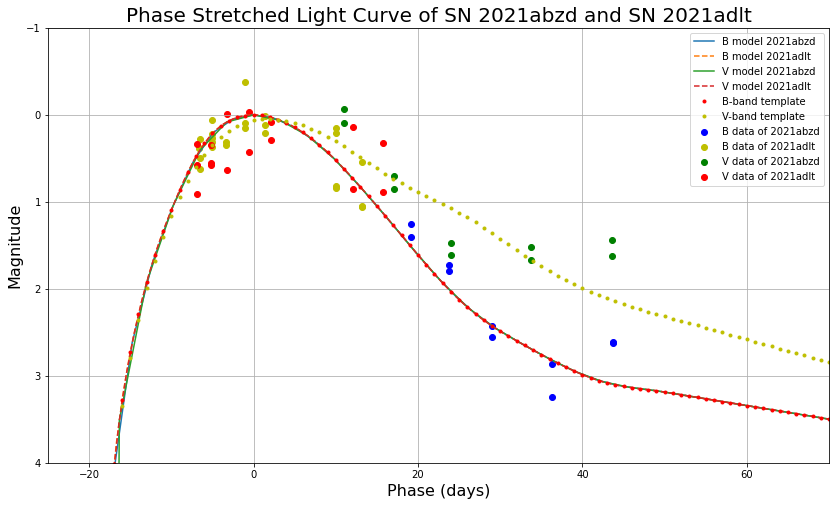

In [321]:
#model time length
t_model = np.arange(jdmax-9, jdmax + 45)
t_model2 = np.arange(jdmax2-30, jdmax2 + 100)
t_modelV = np.arange(jdmaxV-9, jdmaxV + 45)
t_modelV2 = np.arange(jdmaxV2-30, jdmaxV2 + 100)

#model and observation data
model_phase, model_y = target_model(best_fit, t_model)
obs_phase, obs_y = target_model(best_fit, SNdataB1['mjd'])
model_phase2, model_y2 = target_model(best_fit2, t_model2)
obs_phase2, obs_y2 = target_model(best_fit2, SNdataB2['mjd'])
model_phaseV, model_yV = target_model(best_fitV, t_modelV)
obs_phaseV, obs_yV = target_model(best_fitV, SNdataV1['mjd'])
model_phaseV2, model_yV2 = target_model(best_fitV2, t_modelV2)
obs_phaseV2, obs_yV2 = target_model(best_fitV2, SNdataV2['mjd'])

#phase = (SNdataB1['mjd'] - jdmax) / stretch

plt.figure(figsize=(14,8))
plt.plot(model_phase, model_y-peakmag, label='B model 2021abzd')
plt.scatter(obs_phase, (SNdataB1['mag']-ext1_B)-peakmag, c='b', label='B data of 2021abzd') 
plt.plot(model_phase2, model_y2-peakmag2, ls ='--', label='B model 2021adlt')
plt.scatter(obs_phase2, (SNdataB2['mag'])-peakmag2, c='y', label='B data of 2021adlt') 
plt.plot(model_phaseV, model_yV-peakmagV, label='V model 2021abzd')
plt.scatter(obs_phaseV, (SNdataV1['mag']-ext1_V)-peakmagV, c='g', label='V data of 2021abzd') 
plt.plot(model_phaseV2, model_yV2-peakmagV2, ls ='--', label='V model 2021adlt')
plt.scatter(obs_phaseV2, (SNdataV2['mag'])-peakmagV2, c='r', label='V data of 2021adlt')
plt.plot(EHdata['phase'], EHdata['B'], 'r.', label='B-band template')
plt.plot(EHdata['phase'], EHdata['V'], 'y.', label='V-band template')
plt.gca().invert_yaxis()
plt.xlabel('Phase (days)', fontsize=16)
plt.ylabel('Magnitude', fontsize=16)
plt.title('Phase Stretched Light Curve of SN 2021abzd and SN 2021adlt', fontsize=20)
plt.xlim(-25, 70)
plt.ylim(4,-1)
plt.legend()
plt.grid();

Granted while the obseraved data from the observations data with the subtraction of the peak magnitude seem to work, this is without all the galactic extinction. I tried to include it the observation magnitudes but found some students including those who had the same targets applied it before they submitted all the shared data. I tried to see if I can compline them into the chi^2 but would not except for the maximum points and for the set up in the model and chi^2 function. As the graph below shows, I tried then apply them to graph but this causes all my data jump off the models. 

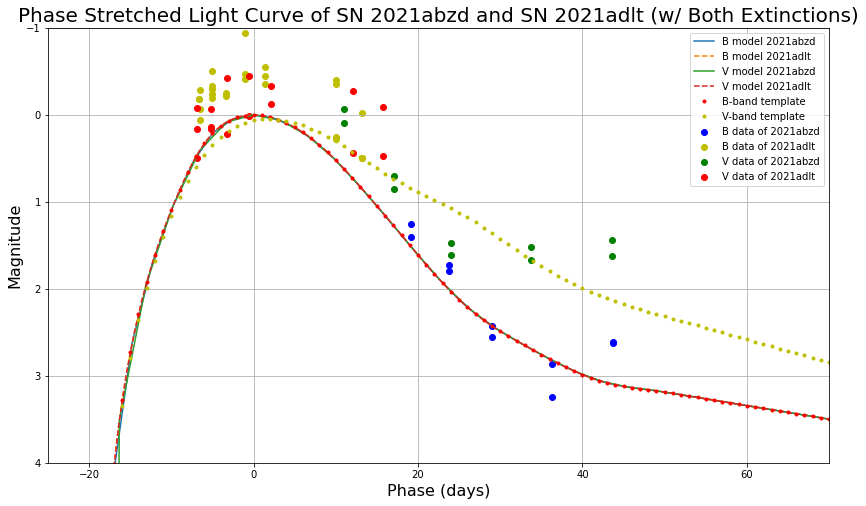

In [323]:
plt.figure(figsize=(14,8))
plt.plot(model_phase, model_y-peakmag, label='B model 2021abzd')
plt.scatter(obs_phase, (SNdataB1['mag']-ext1_B)-peakmag, c='b', label='B data of 2021abzd') #include  - ext1_B if need be
plt.plot(model_phase2, model_y2-peakmag2, ls ='--', label='B model 2021adlt')
plt.scatter(obs_phase2, (SNdataB2['mag']-ext2_B)-peakmag2, c='y', label='B data of 2021adlt') #include  - ext2_B if need be
plt.plot(model_phaseV, model_yV-peakmagV, label='V model 2021abzd')
plt.scatter(obs_phaseV, (SNdataV1['mag']-ext1_V)-peakmagV, c='g', label='V data of 2021abzd') 
plt.plot(model_phaseV2, model_yV2-peakmagV2, ls ='--', label='V model 2021adlt')
plt.scatter(obs_phaseV2, (SNdataV2['mag']-ext2_V)-peakmagV2, c='r', label='V data of 2021adlt')
plt.plot(EHdata['phase'], EHdata['B'], 'r.', label='B-band template')
plt.plot(EHdata['phase'], EHdata['V'], 'y.', label='V-band template')
plt.gca().invert_yaxis()
plt.xlabel('Phase (days)', fontsize=16)
plt.ylabel('Magnitude', fontsize=16)
plt.title('Phase Stretched Light Curve of SN 2021abzd and SN 2021adlt (w/ Both Extinctions)', fontsize=20)
plt.xlim(-25, 70)
plt.ylim(4,-1)
plt.legend()
plt.grid();

So I will have to assume the SN 2021adlt data I did without the galactice extinction is approximately correct since it does show it still follows closely to the template models. The data for SN 2021abzd I applied in the main graph and does slightly fixes the fit to the model.

Now, find the delta_m15.

### 3.3 Calculate $\Delta m_{15}(B)$

In [63]:
phase0 = jdmax #the is the peakmag
phase_int, mag_int = target_model(best_fit, phase0)
phase15 = jdmax + 15
phase_15, mag_15 = target_model(best_fit, phase15)
m15B_abzd = mag_15 - mag_int

phase02 = jdmax2 #peakmag2
phase_int2, mag_int2 = target_model(best_fit2, phase02)
phase152 = jdmax2 + 15
phase_152, mag_152 = target_model(best_fit2, phase152)
m15B_adlt = mag_152 - mag_int2
#m15B_abzd
print(f"The $\Delta m_{15}(B)$ of 2021abzd is {m15B_abzd:.5f} mag.")
print(f"The $\Delta m_{15}(B)$ of 2021adlt is {m15B_adlt:.5f} mag.")

The $\Delta m_15(B)$ of 2021abzd is 2.85024 mag.
The $\Delta m_15(B)$ of 2021adlt is 0.71421 mag.


## Step 4

Using the [Phillips relation](http://adsabs.harvard.edu/abs/1993ApJ...413L.105P) and your measured $\Delta m_{15}$ values, determine the peak absolute magnitudes for your supernovae. Convert this to distance using the peak apparent magnitudes of your light curve fits.

* from page 3 in Phillips paper, you use the least-square fits of $M_{max} = a + b\Delta m_{15}(B)$.
* just plug in Phillips values of a and b for B and V to get M_max.
* and use steps from Project 3 to get the distance. 

From Philips, the least-square fits of $M_{max} = a + b\Delta m_{15}(B)$ is given. For B-band, a = -21.726(0.498) and b = 2.698(0.359) with $\sigma$ = 0.36 mag. For V-band, a = -20.883(0.417) and b = 1.949(0.292) with $\sigma$ = 0.28 mag.

### For B-band

In [326]:
a = -21.726
b = 2.698
M = a + b*m15B_abzd
print("The peak absolute magnitude of 2021abzd is {:.3f} mag.".format(M))

The peak absolute magnitude of 2021abzd is -14.036 mag.


In [252]:
m =peakmag
d = (10**((m - M +5)/5))/1000000 # 1/1000000 to convert pc to Mpc
d
print("The distance of SN 2021abzd in the B-band is {:.3f} Mpc.".format(d))

The distance of SN 2021abzd in the B-band is 3.505 Mpc.


In [327]:
a = -21.726
b = 2.698
M2 = a + b*m15B_adlt
print("The peak absolute magnitude of 2021adlt is {:.3f} mag.".format(M2))

The peak absolute magnitude of 2021adlt is -19.799 mag.


In [254]:
m2 = peakmag
d2 = (10**((m2 - M2 +5)/5))/1000000 # 1/1000000 to convert pc to Mpc
d2
print("The distance of SN 2021adlt in the B-band is {:.3f} Mpc.".format(d2))

The distance of SN 2021adlt in the B-band is 49.806 Mpc.


Attempt at error propagation but ran out of time. Here was what I was going for based on project 3 without bootstrap and some changes I made.

In [278]:
sigma_a = 0.498
sigma_b = 0.359
sigma_p = np.sqrt(1/1*np.sum( (d - jdmax)**2))
A = sigma_a*(np.log10(jdmax))
B = (sigma_p*a)/(jdmax*np.log(10))
sigma_M = np.sqrt((A)**2 + (B)**2 +(sigma_b)**2)
sigma_M

9.736557574664339

In [282]:
d_err = np.log(10)/(5 * np.exp(np.log(10) * (m - M + 5)/5)*sigma_M)
d_err

1.3494596449009455e-08

### For V-band
Based on the Philips (1993), I can apply the $\Delta m_{15}(B)$.

In [328]:
aV = -20.883
bV = 1.949
MV = aV + bV*m15B_abzd
print("The peak absolute magnitude in V-band of 2021abzd is {:.3f} mag.".format(MV))

The peak absolute magnitude in V-band of 2021abzd is -15.328 mag.


In [248]:
mV =peakmagV
dV = (10**((mV - MV +5)/5))/1000000 # 1/1000000 to convert pc to Mpc
print("The distance of SN 2021abzd in the B-band is {:.3f} Mpc.".format(dV))

The distance of SN 2021abzd in the B-band is 7.339 Mpc.


In [329]:
MV2 = aV + bV*m15B_adlt
print("The peak absolute magnitude in V-band of 2021abzd is {:.3f} mag.".format(MV2))

The peak absolute magnitude in V-band of 2021abzd is -19.491 mag.


In [250]:
mV2 =peakmagV2
dV2 = (10**((mV2 - MV2 +5)/5))/1000000 # 1/1000000 to convert pc to Mpc
print("The distance of SN 2021abzd in the B-band is {:.3f} Mpc.".format(dV2))

The distance of SN 2021abzd in the B-band is 136.624 Mpc.


## Step 5

Gather the light curve data of all targets from your classmates and plot your distances (in Mpc) against redshifts (in km/s). Unlike Hubble's original plot, your Hubble diagram should have redshifts along the abscissa and distances on the ordinate (because distance is the more uncertain, dependent variable). 

Fit a line to these data and determine the slope (in km/s/Mpc) and its uncertainty. This is your measurement of the Hubble Constant. Note that the expansion rate is exactly zero at a distance of zero; this constrains the y-intercept of the line, so you only need fit for the slope. Use your measurement to determine the age of the Universe.

* use MCMC fitting to calculate the Hubble constant
* you should fit every light curve you want to use to find the hubble constant
* repeat 3 and 4 to get all the light and the distances

Since only five targets including mine were recorded with their redshifts, z, I will be using them to gather light curve data. 
* 2021abwq is z = 0.08, 2021acxz is z = 0.089, 2021aazk is z = 0.065, 2021abzd is z = 0.018086, 2021adlt is z = 0.021.


### 5.1 Re-processing the best parameters with 2021 and 2020 data

* Will be doing only B-band filters

In [93]:
#Truth array from student data 2021 data
dataB_abwq = SNdataB['name'] == '2021abwq'
dataB_acxz = SNdataB['name'] == '2021acxz'
dataB_aazk = SNdataB['name'] == '2021aazk'
dataB_abzd = SNdataB['name'] == '2021abzd'
dataB_adlt = SNdataB['name'] == '2021adlt'

SNdataB1 = SNdataB[dataB_abzd]
SNdataB2 = SNdataB[dataB_adlt]
SNdataB3 = SNdataB[dataB_abwq]
SNdataB4 = SNdataB[dataB_acxz]
SNdataB5 = SNdataB[dataB_aazk]

In [196]:
SN20dataB

array([('2020aajl', 59173.08 , 'B', 18.644, 0.024),
       ('2020aajl', 59176.125, 'B', 18.141, 0.108),
       ('2020aajl', 59178.079, 'B', 18.125, 0.04 ),
       ('2020aajl', 59178.082, 'B', 18.106, 0.042),
       ('2020aajl', 59182.088, 'B', 18.036, 0.045),
       ('2020aajl', 59182.092, 'B', 18.039, 0.046),
       ('2020aajl', 59190.089, 'B', 18.457, 0.027),
       ('2020ymj', 59159.269, 'B', 19.049, 0.137),
       ('2020ymj', 59159.271, 'B', 18.969, 0.086),
       ('2020ymj', 59165.094, 'B', 19.409, 0.062),
       ('2020ymj', 59169.097, 'B', 19.712, 0.067),
       ('2020ymj', 59171.089, 'B', 19.878, 0.084),
       ('2020ymj', 59173.094, 'B', 20.583, 0.204),
       ('2020ymj', 59178.108, 'B', 20.195, 0.227),
       ('2020ymj', 59178.11 , 'B', 20.031, 0.199),
       ('2020ymj', 59182.11 , 'B', 20.24 , 0.354),
       ('2020ymj', 59190.1  , 'B', 20.399, 0.13 ),
       ('2020yvu', 59169.12 , 'B', 15.7  , 0.016),
       ('2020yvu', 59171.16 , 'B', 15.594, 0.016),
       ('2020yvu', 59173

Adding in last year's data where the redshift is documented on Transeit Name Server.
2020yvu has z = 0.01, 2020ywm is z = 0.047553, 2020ywy is z = 0.04, 2020yzs is z = 0.0672, 2020zbj is z = 0.066, 2020zem is z = 0.034, 2020zhh is z = 0.04, 2020zjn is z = 0.04

In [101]:
SN20colnm = [('name','U20'),('mjd','f8'),('filter','U20'), ('mag','f8'),('emag','f8')]
SN20data = np.genfromtxt('shared_lcs_2020.dat', dtype=SNcolnm)
B = SN20data['filter'] == 'B'
SN20dataB = SN20data[B]
dataB_yvu = SN20dataB['name'] == '2020yvu'
dataB_ywm = SN20dataB['name'] == '2020ywm'
dataB_ywy = SN20dataB['name'] == '2020ywy'
dataB_yzs = SN20dataB['name'] == '2020yzs'
dataB_zbj = SN20dataB['name'] == '2020zbj'
dataB_zem = SN20dataB['name'] == '2020zem'
dataB_zhh = SN20dataB['name'] == '2020zhh'
dataB_zjn = SN20dataB['name'] == '2020zjn'

SN20dataB1 = SN20dataB[dataB_yvu]
SN20dataB2 = SN20dataB[dataB_ywm]
SN20dataB3 = SN20dataB[dataB_ywy]
SN20dataB4 = SN20dataB[dataB_yzs]
SN20dataB5 = SN20dataB[dataB_zbj]
SN20dataB6 = SN20dataB[dataB_zem]
SN20dataB7 = SN20dataB[dataB_zhh]
SN20dataB8 = SN20dataB[dataB_zjn]

In [102]:
#2021 maxs
B3_max = SNdataB3['mag'].min()
w3 = SNdataB3['mag'] == B3_max
jdmax3_0 = SNdataB3[w3]['mjd'][0]
B4_max = SNdataB4['mag'].min()
w4 = SNdataB4['mag'] == B4_max
jdmax4_0 = SNdataB4[w4]['mjd'][0]
B5_max = SNdataB5['mag'].min()
w5 = SNdataB5['mag'] == B5_max
jdmax5_0 = SNdataB5[w5]['mjd'][0]

#2020 maxs
B1_max20 = SN20dataB1['mag'].min()
w201 = SN20dataB1['mag'] == B1_max20
jdmax201_0 = SN20dataB1[w201]['mjd'][0]
B2_max20 = SN20dataB2['mag'].min()
w202 = SN20dataB2['mag'] == B2_max20
jdmax202_0 = SN20dataB2[w202]['mjd'][0]
B3_max20 = SN20dataB3['mag'].min()
w203 = SN20dataB3['mag'] == B3_max20
jdmax203_0 = SN20dataB3[w203]['mjd'][0]
B4_max20 = SN20dataB4['mag'].min()
w204 = SN20dataB4['mag'] == B4_max20
jdmax204_0 = SN20dataB4[w204]['mjd'][0]
B5_max20 = SN20dataB5['mag'].min()
w205 = SN20dataB5['mag'] == B5_max20
jdmax205_0 = SN20dataB5[w205]['mjd'][0]
B6_max20 = SN20dataB6['mag'].min()
w206 = SN20dataB6['mag'] == B6_max20
jdmax206_0 = SN20dataB6[w206]['mjd'][0]
B7_max20 = SN20dataB7['mag'].min()
w207 = SN20dataB7['mag'] == B7_max20
jdmax207_0 = SN20dataB7[w207]['mjd'][0]
B8_max20 = SN20dataB8['mag'].min()
w208 = SN20dataB8['mag'] == B8_max20
jdmax208_0 = SN20dataB8[w208]['mjd'][0]

In [106]:
#parameters for the remaining three 2021 candidates
guess3 = (jdmax3_0, 1, B3_max) 
data3 = SNdataB3
chisq3=get_chisq(guess3, data3)
guess4 = (jdmax4_0, 1, B4_max) #guess of the parameters
data4 = SNdataB4
chisq4=get_chisq(guess4, data4)
guess5 = (jdmax5_0, 1, B5_max) #guess of the parameters
data5 = SNdataB5
chisq5=get_chisq(guess5, data5)
chisq3, chisq4, chisq5

(435.08927828365347, 226.2545238114498, 93.05744801366816)

In [109]:
#chi^2 for 2020 data
guess201 = (jdmax201_0, 1, B1_max20) 
data201 = SN20dataB1
chisq201=get_chisq(guess201, data201)
guess202 = (jdmax202_0, 1, B2_max20) 
data202 = SN20dataB2
chisq202=get_chisq(guess202, data202)
guess203 = (jdmax203_0, 1, B3_max20) 
data203 = SN20dataB3
chisq203=get_chisq(guess203, data203)
guess204 = (jdmax204_0, 1, B4_max20) 
data204 = SN20dataB4
chisq204=get_chisq(guess204, data204)
guess205 = (jdmax205_0, 1, B5_max20) 
data205 = SN20dataB5
chisq205=get_chisq(guess205, data205)
guess206 = (jdmax206_0, 1, B6_max20) 
data206 = SN20dataB6
chisq206=get_chisq(guess206, data206)
guess207 = (jdmax207_0, 1, B7_max20) 
data207 = SN20dataB7
chisq207=get_chisq(guess207, data207)
guess208 = (jdmax208_0, 1, B8_max20) 
data208 = SN20dataB8
chisq208=get_chisq(guess208, data208)
chisq201, chisq202, chisq203, chisq204, chisq205, chisq206, chisq207, chisq208

(174.88757314643354,
 28.059711110588456,
 55.34594809195694,
 2.5619514139530954,
 57.894530418971044,
 394.349572723383,
 6455.373735773603,
 8129.26428394732)

In [110]:
best_fit3 = fmin(get_chisq, guess3, args=(data3,))
best_fit4 = fmin(get_chisq, guess4, args=(data4,))
best_fit5 = fmin(get_chisq, guess5, args=(data5,))

Optimization terminated successfully.
         Current function value: 128.147770
         Iterations: 225
         Function evaluations: 398
Optimization terminated successfully.
         Current function value: 57.765174
         Iterations: 94
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: 9.470169
         Iterations: 197
         Function evaluations: 347


In [113]:
best_fit201 = fmin(get_chisq, guess201, args=(data201,))
best_fit202 = fmin(get_chisq, guess202, args=(data202,))
best_fit203 = fmin(get_chisq, guess203, args=(data203,))
best_fit204 = fmin(get_chisq, guess204, args=(data204,))
best_fit205 = fmin(get_chisq, guess205, args=(data205,))
best_fit206 = fmin(get_chisq, guess206, args=(data206,))
best_fit207 = fmin(get_chisq, guess207, args=(data207,))
best_fit208 = fmin(get_chisq, guess208, args=(data208,))

Optimization terminated successfully.
         Current function value: 4.307404
         Iterations: 77
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: 5.385626
         Iterations: 98
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: 13.765118
         Iterations: 140
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: 0.754821
         Iterations: 89
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: 1.862658
         Iterations: 109
         Function evaluations: 200
Optimization terminated successfully.
         Current function value: 9.982762
         Iterations: 75
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 0.512717
         Iterations: 93
         Function evaluations: 170
Optimization terminated 

In [115]:
#2021
jdmax3, stretch3, peakmag3 = best_fit3[0], best_fit3[1], best_fit3[2]
jdmax4, stretch4, peakmag4 = best_fit4[0], best_fit4[1], best_fit4[2]
jdmax5, stretch5, peakmag5 = best_fit5[0], best_fit5[1], best_fit5[2]
#2020
jdmax201, stretch201, peakmag201 = best_fit201[0], best_fit201[1], best_fit201[2]
jdmax202, stretch202, peakmag202 = best_fit202[0], best_fit202[1], best_fit202[2]
jdmax203, stretch203, peakmag203 = best_fit203[0], best_fit203[1], best_fit203[2]
jdmax204, stretch204, peakmag204 = best_fit204[0], best_fit204[1], best_fit204[2]
jdmax205, stretch205, peakmag205 = best_fit205[0], best_fit205[1], best_fit205[2]
jdmax206, stretch206, peakmag206 = best_fit206[0], best_fit206[1], best_fit206[2]
jdmax207, stretch207, peakmag207 = best_fit207[0], best_fit207[1], best_fit207[2]
jdmax208, stretch208, peakmag208 = best_fit208[0], best_fit208[1], best_fit208[2]

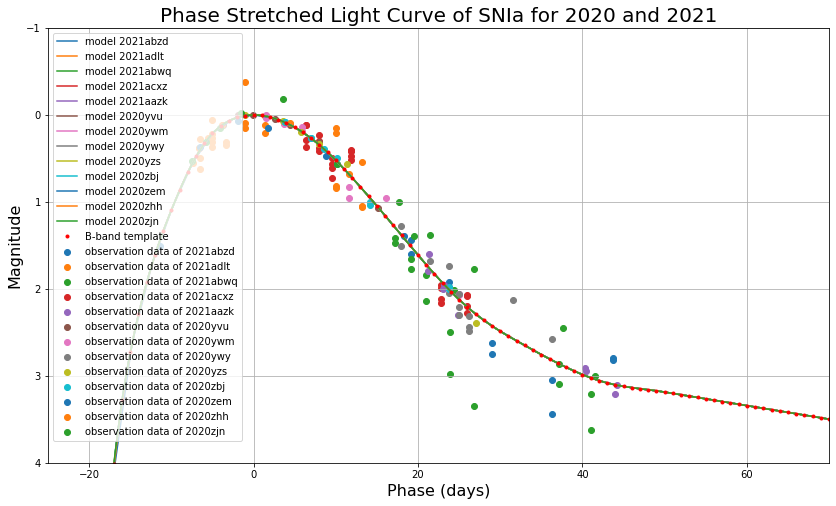

In [330]:
#model jd range
t_model3 = np.arange(jdmax3-30, jdmax3 + 100)
t_model4 = np.arange(jdmax4-30, jdmax4 + 100)
t_model5 = np.arange(jdmax5-30, jdmax5 + 100)
t_model201 = np.arange(jdmax201-30, jdmax201 + 100)
t_model202 = np.arange(jdmax202-30, jdmax202 + 100)
t_model203 = np.arange(jdmax203-30, jdmax203 + 100)
t_model204 = np.arange(jdmax204-30, jdmax204 + 100)
t_model205 = np.arange(jdmax205-30, jdmax205 + 100)
t_model206 = np.arange(jdmax206-30, jdmax206 + 100)
t_model207 = np.arange(jdmax207-30, jdmax207 + 100)
t_model208 = np.arange(jdmax208-30, jdmax208 + 100)
#model and observation data
model_phase3, model_y3 = target_model(best_fit3, t_model3)
obs_phase3, obs_y3 = target_model(best_fit3, SNdataB3['mjd'])
model_phase4, model_y4 = target_model(best_fit4, t_model4)
obs_phase4, obs_y4 = target_model(best_fit4, SNdataB4['mjd'])
model_phase5, model_y5 = target_model(best_fit5, t_model5)
obs_phase5, obs_y5 = target_model(best_fit5, SNdataB5['mjd'])
model_phase201, model_y201 = target_model(best_fit201, t_model201)
obs_phase201, obs_y201 = target_model(best_fit201, SN20dataB1['mjd'])
model_phase202, model_y202 = target_model(best_fit202, t_model202)
obs_phase202, obs_y202 = target_model(best_fit202, SN20dataB2['mjd'])
model_phase203, model_y203 = target_model(best_fit203, t_model203)
obs_phase203, obs_y203 = target_model(best_fit203, SN20dataB3['mjd'])
model_phase204, model_y204 = target_model(best_fit204, t_model204)
obs_phase204, obs_y204 = target_model(best_fit204, SN20dataB4['mjd'])
model_phase205, model_y205 = target_model(best_fit205, t_model205)
obs_phase205, obs_y205 = target_model(best_fit205, SN20dataB5['mjd'])
model_phase206, model_y206 = target_model(best_fit206, t_model206)
obs_phase206, obs_y206 = target_model(best_fit206, SN20dataB6['mjd'])
model_phase207, model_y207 = target_model(best_fit207, t_model207)
obs_phase207, obs_y207 = target_model(best_fit207, SN20dataB7['mjd'])
model_phase208, model_y208 = target_model(best_fit208, t_model208)
obs_phase208, obs_y208 = target_model(best_fit208, SN20dataB8['mjd'])
#plot
plt.figure(figsize=(14,8))
plt.plot(model_phase, model_y-peakmag, label='model 2021abzd')
plt.scatter(obs_phase, SNdataB1['mag']-peakmag, label='observation data of 2021abzd') #include  - ext1_B if need be
plt.plot(model_phase2, model_y2-peakmag2, label='model 2021adlt')
plt.scatter(obs_phase2, SNdataB2['mag']-peakmag2, label='observation data of 2021adlt') #include  - ext2_B if need be
plt.plot(model_phase3, model_y3-peakmag3, label='model 2021abwq')
plt.scatter(obs_phase3, SNdataB3['mag']-peakmag3, label='observation data of 2021abwq')
plt.plot(model_phase4, model_y4-peakmag4, label='model 2021acxz')
plt.scatter(obs_phase4, SNdataB4['mag']-peakmag4, label='observation data of 2021acxz')
plt.plot(model_phase5, model_y5-peakmag5, label='model 2021aazk')
plt.scatter(obs_phase5, SNdataB5['mag']-peakmag5, label='observation data of 2021aazk')
plt.plot(model_phase201, model_y201-peakmag201, label='model 2020yvu')
plt.scatter(obs_phase201, SN20dataB1['mag']-peakmag201, label='observation data of 2020yvu')
plt.plot(model_phase202, model_y202-peakmag202, label='model 2020ywm')
plt.scatter(obs_phase202, SN20dataB2['mag']-peakmag202, label='observation data of 2020ywm')
plt.plot(model_phase203, model_y203-peakmag203, label='model 2020ywy')
plt.scatter(obs_phase203, SN20dataB3['mag']-peakmag203, label='observation data of 2020ywy')
plt.plot(model_phase204, model_y204-peakmag204, label='model 2020yzs')
plt.scatter(obs_phase204, SN20dataB4['mag']-peakmag204, label='observation data of 2020yzs')
plt.plot(model_phase205, model_y205-peakmag205, label='model 2020zbj')
plt.scatter(obs_phase205, SN20dataB5['mag']-peakmag205, label='observation data of 2020zbj')
plt.plot(model_phase206, model_y206-peakmag206, label='model 2020zem')
plt.scatter(obs_phase206, SN20dataB6['mag']-peakmag206, label='observation data of 2020zem')
plt.plot(model_phase207, model_y207-peakmag207, label='model 2020zhh')
plt.scatter(obs_phase207, SN20dataB7['mag']-peakmag207, label='observation data of 2020zhh')
plt.plot(model_phase208, model_y208-peakmag208, label='model 2020zjn')
plt.scatter(obs_phase208, SN20dataB8['mag']-peakmag208, label='observation data of 2020zjn')
plt.plot(EHdata['phase'], EHdata['B'], 'r.', label='B-band template')
plt.xlabel('Phase (days)', fontsize=16)
plt.ylabel('Magnitude', fontsize=16)
plt.title('Phase Stretched Light Curve of SNIa for 2020 and 2021', fontsize=20)
plt.gca().invert_yaxis()
plt.xlim(-25, 70)
plt.ylim(4,-1)
plt.legend()
plt.grid();

### 5.2 Calculating $\Delta m_{15} (B)$

In [120]:
#calculating m15 for 2021 SN
phase03 = jdmax3 #the is the peakmag
phase_in3, mag_int3 = target_model(best_fit3, phase03)
phase153 = jdmax3 + 15
phase_153, mag_153 = target_model(best_fit3, phase153)
m15B_abwq = mag_153 - mag_int3
phase04 = jdmax4 
phase_int4, mag_int4 = target_model(best_fit4, phase04)
phase154 = jdmax4 + 15
phase_154, mag_154 = target_model(best_fit4, phase154)
m15B_acxz = mag_154 - mag_int4
phase05 = jdmax5
phase_int5, mag_int5 = target_model(best_fit5, phase05)
phase155 = jdmax5 + 15
phase_155, mag_155 = target_model(best_fit5, phase155)
m15B_aazk = mag_155 - mag_int5
m15B_abwq, m15B_acxz, m15B_aazk

(0.9671834435772446, 0.6929326282976014, 0.9048710370570738)

In [123]:
#calculating m15 for 2020 SN
phase0_1 = jdmax201
phase_int_1, mag_int_1 = target_model(best_fit201, phase0_1)
phase15_1 = jdmax201 + 15
phase_15_1, mag_15_1 = target_model(best_fit201, phase15_1)
m15B_yvu = mag_15_1 - mag_int_1
phase0_2 = jdmax202
phase_int_2, mag_int_2 = target_model(best_fit202, phase0_2)
phase15_2 = jdmax202 + 15
phase_15_2, mag_15_2 = target_model(best_fit202, phase15_2)
m15B_ywm = mag_15_2 - mag_int_2
phase0_3 = jdmax203
phase_int_3, mag_int_3 = target_model(best_fit203, phase0_3)
phase15_3 = jdmax203 + 15
phase_15_3, mag_15_3 = target_model(best_fit203, phase15_3)
m15B_ywy = mag_15_3 - mag_int_3
phase0_4 = jdmax204
phase_int_4, mag_int_4 = target_model(best_fit204, phase0_4)
phase15_4 = jdmax204 + 15
phase_15_4, mag_15_4 = target_model(best_fit204, phase15_4)
m15B_yzs = mag_15_4 - mag_int_4
phase0_5 = jdmax205
phase_int_5, mag_int_5 = target_model(best_fit205, phase0_5)
phase15_5 = jdmax205 + 15
phase_15_5, mag_15_5 = target_model(best_fit205, phase15_5)
m15B_zbj = mag_15_5 - mag_int_5
phase0_6 = jdmax206
phase_int_6, mag_int_6 = target_model(best_fit206, phase0_6)
phase15_6 = jdmax206 + 15
phase_15_6, mag_15_6 = target_model(best_fit206, phase15_6)
m15B_zem = mag_15_6 - mag_int_6
phase0_7 = jdmax207
phase_int_7, mag_int_7 = target_model(best_fit207, phase0_7)
phase15_7 = jdmax207 + 15
phase_15_7, mag_15_7 = target_model(best_fit207, phase15_7)
m15B_zhh = mag_15_7 - mag_int_7
phase0_8 = jdmax208
phase_int_8, mag_int_8 = target_model(best_fit208, phase0_8)
phase15_8 = jdmax208 + 15
phase_15_8, mag_15_8 = target_model(best_fit208, phase15_8)
m15B_zjn = mag_15_8 - mag_int_8

m15B_yvu, m15B_ywm, m15B_ywy, m15B_yzs, m15B_zbj, m15B_zem, m15B_zhh, m15B_zjn

(0.8780526271115949,
 1.2442164473233142,
 0.4227855061416399,
 1.2518067500446257,
 0.7216857531800009,
 1.358453856309584,
 0.8889712976291619,
 0.7926505006045055)

### 5.3 Calculating peak absolute magnitudes and distances

In [223]:
a = -21.726
b = 2.698
M3 = a + b*m15B_abwq
M4 = a + b*m15B_acxz
M5 = a + b*m15B_aazk
M6 = a + b*m15B_yvu
M7 = a + b*m15B_ywm
M8 = a + b*m15B_ywy
M9 = a + b*m15B_yzs
M10 = a + b*m15B_zbj
M11 = a + b*m15B_zem
M12 = a + b*m15B_zhh
M13 = a + b*m15B_zjn

In [224]:
m3 = peakmag3
d3 = (10**((m3 - M3 +5)/5))/1000000 
m4 = peakmag4
d4 = (10**((m4 - M4 +5)/5))/1000000 
m5 = peakmag5
d5 = (10**((m5 - M5 +5)/5))/1000000 
m6 = peakmag201
d6 = (10**((m6 - M6 +5)/5))/1000000 
m7 = peakmag202
d7 = (10**((m7 - M7 +5)/5))/1000000 
m8 = peakmag203
d8 = (10**((m8 - M8 +5)/5))/1000000 
m9 = peakmag204
d9 = (10**((m9 - M9 +5)/5))/1000000 
m10 = peakmag205
d10 = (10**((m10 - M10 +5)/5))/1000000 
m11 = peakmag206
d11 = (10**((m11 - M11 +5)/5))/1000000 
m12 = peakmag207
d12 = (10**((m12 - M12 +5)/5))/1000000 
m13 = peakmag208
d13 = (10**((m13 - M13 +5)/5))/1000000 

### 5.4 Obtaining Hubble's constant
##### * First try was with ALL of SN 2020 and 2021 data

In [258]:
distance= [d, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12, d13]
distance

[3.5049380517916076,
 49.806043134846135,
 253.4607980215354,
 482.23385986446914,
 293.2493255785197,
 97.55262957919899,
 248.97471849281558,
 446.96959565196426,
 253.4450434820178,
 479.38955284596057,
 100.5647978103334,
 165.64448070391603,
 257.48024311895426]


* 2021abzd is z = 0.018086, 2021adlt is z = 0.021, 2021abwq is z = 0.08, 2021acxz is z = 0.089, 2021aazk is z = 0.065,  2020yvu has z = 0.01, 2020ywm is z = 0.047553, 2020ywy is z = 0.04, 2020yzs is z = 0.0672, 2020zbj is z = 0.066, 2020zem is z = 0.034, 2020zhh is z = 0.04, 2020zjn is z = 0.04

To get the redshift velocity, v = zc where c is the speed of light 3x10^{5} km/s

In [226]:
z = [0.018086, 0.021, 0.08, 0.089, 0.065, 0.01, 0.047553, 0.04, 0.0672, 0.066, 0.034, 0.04, 0.04]
z_array = np. array(z)
redshifts = z_array * 3e5 # speed of light, 3e5
redshifts

array([ 5425.8,  6300. , 24000. , 26700. , 19500. ,  3000. , 14265.9,
       12000. , 20160. , 19800. , 10200. , 12000. , 12000. ])

In [265]:
#Using the matrix set up from Project 2
def X_matrix(z):
    X = []
    for zi in z:
        X.append([zi]) #based on how I set up the distance array, I was able to get away without a zero/initial value
    return np.matrix(X)

def Y_matrix(d):
    Y = []
    for di in d:
        Y.append([di])
    return np.matrix(Y)

def parameters(z, d):
    X = X_matrix(z)
    Y = Y_matrix(d)
    p = (X.T * X).I * (X.T * Y)
    #for calculating the uncerntaties in data
    fit_Y = X *p
    dy = Y - fit_Y
    s_var = dy.var(ddof = p.shape[0])
    p_var = s_var*np.diagonal((X.T*X).I)
    p_err = np.sqrt(p_var)
    
    return p, p_err

In [339]:
p, p_err = parameters(redshifts, distance)
h1 = 1/float(p[0])
h1_err = p_err[0]/(float(p[0])**2)
print("First try on all 2020 and 2021 data provides the Hubble constant at {:02f} +/- {:02f} km/s/Mpc.".format(h1,h1_err))

First try on all 2020 and 2021 data provides the Hubble constant at 59.816712 +/- 6.650382 km/s/Mpc.


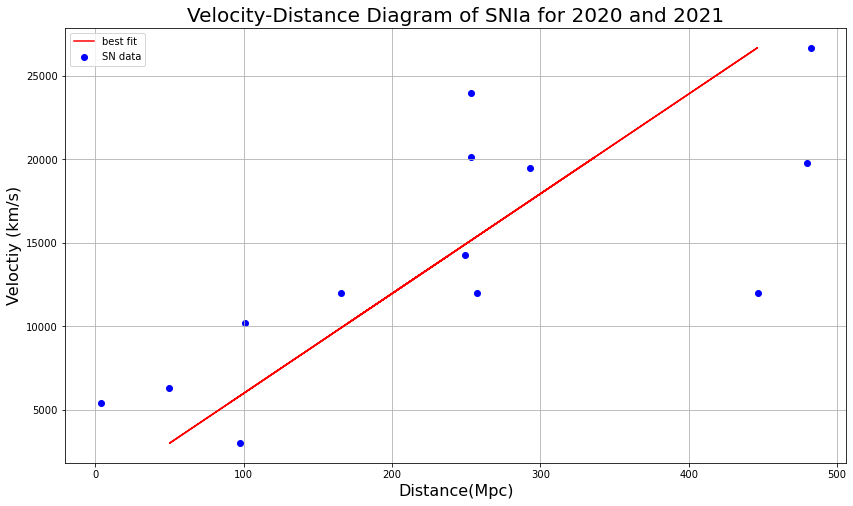

In [341]:
plt.figure(figsize=(14,8))
plt.scatter(distance, redshifts, c='b', label='SN data')
plt.plot(redshifts*p.item(0), redshifts, c='r', label='best fit')
plt.xlabel('Distance(Mpc)', fontsize=16)
plt.ylabel('Veloctiy (km/s)', fontsize=16)
plt.title('Velocity-Distance Diagram of SNIa for 2020 and 2021', fontsize=20)
plt.legend()
plt.grid();

It seems the Hubble's constant is low. To check, I just use only the 5 targets from the 2021 observations.

In [271]:
distance2021= [d, d2, d3, d4, d5]
z_2021 = [0.018086, 0.021, 0.08, 0.089, 0.065]
z_array_2021 = np. array(z_2021)
redshifts_2021 = z_array_2021 * 3e5
redshifts_2021

array([ 5425.8,  6300. , 24000. , 26700. , 19500. ])

In [346]:
p2021, p2021_err = parameters(redshifts_2021, distance2021)
h2 = 1/float(p2021[0])
h2_err = p2021_err[0]/(float(p2021[0])**2)
print("Using only 2021 data, the Hubble constant is at {:02f} +/- {:02f} km/s/Mpc.".format(h2,h2_err))

Using only 2021 data, the Hubble constant is at 69.503359 +/- 8.896327 km/s/Mpc.


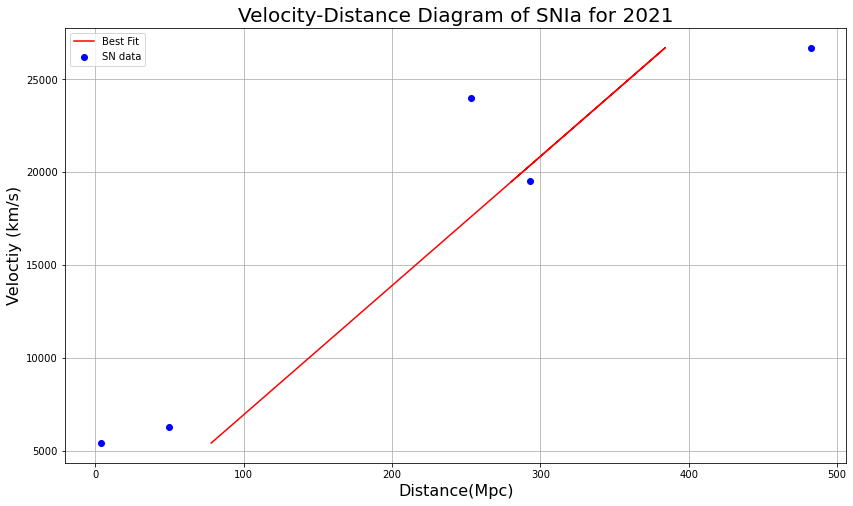

In [345]:
plt.figure(figsize=(14,8))
plt.scatter(distance2021, redshifts_2021, c='b', label='SN data')
plt.plot(redshifts_2021*p2021.item(0), redshifts_2021, c='r', label='Best Fit')
plt.xlabel('Distance(Mpc)', fontsize=16)
plt.ylabel('Veloctiy (km/s)', fontsize=16)
plt.title('Velocity-Distance Diagram of SNIa for 2021', fontsize=20)
plt.legend()
plt.grid();

Now try to keep the data from 2020 and remove the most distance objects that might be causing weight.

In [259]:
distance

[3.5049380517916076,
 49.806043134846135,
 253.4607980215354,
 482.23385986446914,
 293.2493255785197,
 97.55262957919899,
 248.97471849281558,
 446.96959565196426,
 253.4450434820178,
 479.38955284596057,
 100.5647978103334,
 165.64448070391603,
 257.48024311895426]

In [263]:
distance[3], distance[7], distance[9]

(482.23385986446914, 446.96959565196426, 479.38955284596057)

In [264]:
z[3],z[7], z[9]

(0.089, 0.04, 0.066)

Removing 2021acxz, 2020ywy, 2020zbj.

In [274]:
distance_weight= [d, d2, d3, d5, d6, d7, d9, d11, d12, d13]
z_weight = [0.018086, 0.021, 0.08, 0.065, 0.01, 0.047553, 0.0672, 0.034, 0.04, 0.04]
z_array_weight = np. array(z_weight)
redshifts_weight = z_array_weight * 3e5
distance_weight

[3.5049380517916076,
 49.806043134846135,
 253.4607980215354,
 293.2493255785197,
 97.55262957919899,
 248.97471849281558,
 253.4450434820178,
 100.5647978103334,
 165.64448070391603,
 257.48024311895426]

In [347]:
pw, pw_err = parameters(redshifts_weight, distance_weight)
h3 = 1/float(pw[0])
h3_err = pw_err[0]/(float(pw[0])**2)
print("Removing 2021acxz, 2020ywy, 2020zb, the Hubble constant is at {:02f} +/- {:02f} km/s/Mpc.".format(h3,h3_err))

Removing 2021acxz, 2020ywy, 2020zb, the Hubble constant is at 74.889796 +/- 7.072261 km/s/Mpc.


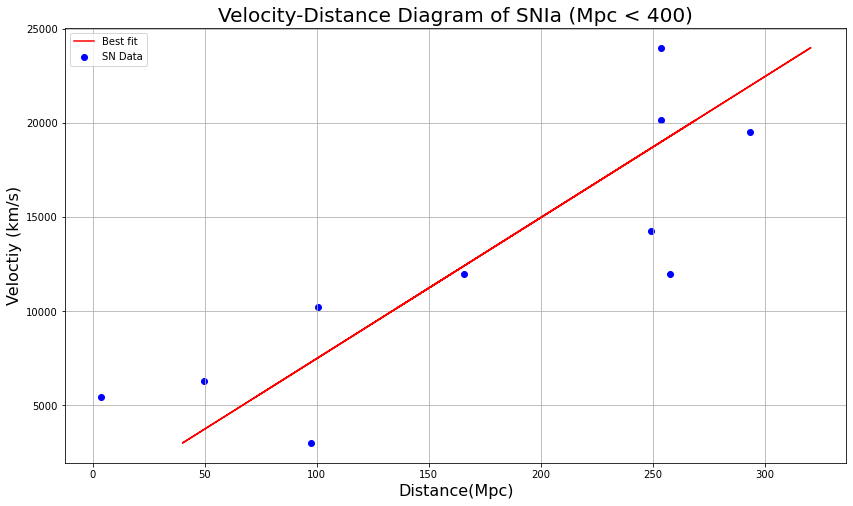

In [348]:
plt.figure(figsize=(14,8))
plt.scatter(distance_weight, redshifts_weight, c='b', label='SN Data')
plt.plot(redshifts_weight*pw.item(0), redshifts_weight, c='r', label='Best fit')
plt.xlabel('Distance(Mpc)', fontsize=16)
plt.ylabel('Veloctiy (km/s)', fontsize=16)
plt.title('Velocity-Distance Diagram of SNIa (Mpc < 400)', fontsize=20)
plt.legend()
plt.grid();

Based on the Hubble's constant from Riess et al. 2019, the third attempt with the distance of the SNIa objects kept under 400 Mpc has the closest match to their $H_{0}$ with it approximately 74.9 +/- 7.1 km/s/Mpc. Even the second attempt with only 2021 observations was close to $H_{0}$ in Riess et al. 2019. Does seem to show that the targets do make a distance in establishing a cosmic ladder to measure $H_{0}$. This will be explained more in the paper portion of this project.

In [8]:
#age of the universe
H0 = 74.889796
age = 1/(H0*(1/206265e6)*(1/149597871))*(1/(3600*365.25*24))*u.yr
print('Age of the Universe {:03f},'.format(age))
print('or 13.06 billion years old.')

Age of the Universe 13056426834.458849 yr,
or 13.06 billion years old.


In [3]:
3.09e19

3.09e+19

## Step 6

Writeup your work in ApJ format using $\LaTeX$ including figures and citations properly referenced in the text. Make sure you fully explain everything you did from taking and processing the data to analyzing your results. This is your opportunity to demonstrate what you have learned in this course.

When finished, submit your jupyter notebook and the PDF of your report to GitHub.